# Notebook Dedicado a correguir la Transformación de MC Dataset para entrenar el MML y Obtener un Modelo Clasificador Optimizado

Fue observado al hacer predicciones en el datos reales que los clasificacion de evento como BAB caen en energias donde no son esperados observar eventos de bkg. Originalmente la transformacion standard scaler era aplicado a talio y 8B Nue por separado, lo cual no es posible realizar en datos reales. Por lo tanto debemos sumar las distribuciones de eventos de bkg y eventos de sig y transformar todo el conjunto para ser consistente con el tratamiento de datos reales.

In [1]:
#import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# Load Data

In [3]:
image_dim = (10, 10)

#Directories
train_dataset_dir = "Data/High Stat/Elegant Data Frame Structure/train/df1_5500_10_(2.5_14)_(-5_7).csv"
test_dataset_dir = "Data/High Stat/Elegant Data Frame Structure/test/df2_test_5500_10_(2.5_14)_(-5_7).csv"

#Load in Pandas  DataFrame
df_train = shuffle(pd.read_csv(train_dataset_dir))
df_test = shuffle(pd.read_csv(test_dataset_dir))

In [4]:
df_train.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,...,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000
mean,43399.000000,0.103205,0.088559,0.097311,0.101131,0.101650,0.102036,0.102622,0.102890,0.103442,...,0.100280,0.100717,0.100868,0.101956,0.102550,0.103799,4.426912,4098.779480,0.500000,0.500000
std,25056.785175,0.255754,0.217296,0.196318,0.174071,0.154458,0.139249,0.126640,0.115322,0.105307,...,0.150967,0.136518,0.123935,0.113753,0.103857,0.095470,1.597788,1070.793561,0.500001,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500081,68.754494,0.000000,0.000000
25%,21699.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.029412,...,0.000000,0.000000,0.000000,0.022727,0.029412,0.034483,3.441121,3427.102417,0.000000,0.000000
50%,43399.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.047619,0.055556,0.062500,0.068966,...,0.031250,0.047619,0.055556,0.062500,0.068966,0.075000,3.875119,4336.404053,0.500000,0.500000
75%,65098.750000,0.000000,0.000000,0.111111,0.142857,0.142857,0.150000,0.150000,0.148148,0.148148,...,0.142857,0.142857,0.146341,0.147059,0.147059,0.147059,4.785668,4974.712646,1.000000,1.000000
max,86798.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.896552,0.816327,0.833333,...,1.000000,1.000000,0.909091,0.791667,0.840000,0.818182,13.546737,5499.991211,1.000000,1.000000


In [5]:
df_test.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,...,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000
mean,23260.000000,0.102381,0.086131,0.096609,0.100616,0.101405,0.101727,0.101638,0.101978,0.102806,...,0.100970,0.101846,0.102335,0.103169,0.103960,0.105062,4.420709,4100.394531,0.500000,0.500000
std,13429.528103,0.255092,0.214259,0.195932,0.174412,0.154686,0.139989,0.126693,0.115149,0.105888,...,0.151606,0.137405,0.124569,0.113891,0.104821,0.096305,1.587834,1070.269563,0.500003,0.500003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500030,106.154373,0.000000,0.000000
25%,11630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.028571,...,0.000000,0.000000,0.000000,0.023256,0.029851,0.035088,3.440157,3427.727112,0.000000,0.000000
50%,23260.000000,0.000000,0.000000,0.000000,0.000000,0.023533,0.047619,0.052632,0.061224,0.068182,...,0.032258,0.050000,0.055556,0.062500,0.071429,0.076923,3.873259,4335.557373,0.500000,0.500000
75%,34890.000000,0.000000,0.000000,0.111111,0.142857,0.142857,0.148148,0.148148,0.147059,0.147059,...,0.142857,0.148148,0.150000,0.150000,0.148649,0.148148,4.795290,4979.039795,1.000000,1.000000
max,46520.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.870968,0.814815,0.821429,...,1.000000,1.000000,0.857143,0.785714,0.766667,0.750000,13.663218,5499.998047,1.000000,1.000000


# Data Procesing

## Extract information and Define Energy Cuts

In [42]:
pixel_pattern = r'^pixel_\d+$'

energy_cut_train = 12
energy_cut_test = 12

### Extract Trainning Data

In [43]:
#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#cut in solar energy
dataset_sig_train = (dataset_sig_train[dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])
    
# Separate Features for signal and background: Useful for plots
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

# Also save the join bkg+sig datasets and its labels to perform the standard scaler overall data
df_pixel_train = pd.concat([df_pixel_sig_train, df_pixel_bkg_train])
df_energy_train = pd.concat([df_energy_sig_train, df_energy_bkg_train])
df_radi_train = pd.concat([df_radi_sig_train, df_radi_bkg_train])
df_labels_train = pd.concat([df_label_sig_train, df_label_bkg_train])
labels_train = np.array(df_labels_train)

### Extract Test Data

In [44]:
equal_evs = True #Cambiar a True para Igualar eventos de 208-Tl y Solar Nu en test dataset!

#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1]).drop(columns=['Unnamed: 0'])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test])

if equal_evs:
    #Igualar cantidad de datos de neutrinos solares y de Tálio
    N_solar_ev = dataset_sig_test.shape[0]
    N_Tl_ev = dataset_bkg_test.shape[0]
    
    if N_solar_ev > N_Tl_ev:
        dataset_sig_test = (dataset_sig_test.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])
    
    else:
        dataset_bkg_test = (dataset_bkg_test.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])

df_test_cut = shuffle(pd.concat([dataset_sig_test, dataset_bkg_test]))
        

#Separate Features for signal and background: Useful for plots
df_pixel_test = df_test_cut.filter(regex=pixel_pattern)
df_energy_test = df_test_cut[['energy (MeV)']]
df_radi_test = df_test_cut[['radius (mm)']]
df_labels_test = pd.DataFrame(df_test_cut, columns = ['IsNu', 'IsTl'])
labels_test = np.array(df_labels_test)

## Data Transformation

### Standard Scaler

In [9]:
# Train Transformation History
scaler_pixels_train = StandardScaler() 
scaler_energy_train = StandardScaler()
scaler_position_train = StandardScaler()

# Test Transformation History
scaler_pixels_test = StandardScaler() 
scaler_energy_test = StandardScaler() 
scaler_position_test = StandardScaler()

### Pipeline MinMaxScaler(StandardScaler())

In [45]:
# Train Transformation History
scaler_pixels_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_energy_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_position_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
# Test Transformation History
scaler_pixels_test = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_energy_test = Pipeline([('standardization', StandardScaler()),
                               ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_position_test = Pipeline([('standardization', StandardScaler()),
                                 ('minmax', MinMaxScaler(feature_range=(-1, 1)))])

### Train Dataset Transformation

In [46]:
pixel_train_transf = scaler_pixels_train.fit_transform(df_pixel_train)
energy_train_transf = scaler_energy_train.fit_transform(df_energy_train).T[0]

#radial position to volume normalization Transformationm
vol = 5500**3 
position_train_transf_volnorm = (np.array(df_radi_train).T[0]**3)/vol

position_train_transf = scaler_position_train.fit_transform(position_train_transf_volnorm.reshape(-1, 1)).T[0]

### Test Dataset Transformation

In [47]:
pixel_test_transf = scaler_pixels_test.fit_transform(df_pixel_test)
energy_test_transf = scaler_energy_test.fit_transform(df_energy_test).T[0]

#radial position to volume normalization Transformationm
vol = 5500**3 
position_test_transf_volnorm = (np.array(df_radi_test).T[0]**3)/vol

position_test_transf = scaler_position_test.fit_transform(position_test_transf_volnorm.reshape(-1, 1)).T[0]

### Separation of sig from bkg in the Train and Test Datasets

In [48]:
#Separar sig from bkg and train from test
IsNu = np.array([1,0])
IsTl = np.array([0,1])

#Train: Separation sig from bkg
pixel_train_transf_sig = pixel_train_transf[np.array(df_labels_train == IsNu)[:,0]]
pixel_train_transf_bkg = pixel_train_transf[np.array(df_labels_train == IsTl)[:,0]]

energy_train_transf_sig = energy_train_transf[np.array(df_labels_train == IsNu)[:,0]]
energy_train_transf_bkg = energy_train_transf[np.array(df_labels_train == IsTl)[:,0]]

position_train_transf_sig = position_train_transf[np.array(df_labels_train == IsNu)[:,0]]
position_train_transf_bkg = position_train_transf[np.array(df_labels_train == IsTl)[:,0]]

#Test: Separation sig from bkg
pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

energy_test_transf_sig = energy_test_transf[np.array(df_labels_test == IsNu)[:,0]]
energy_test_transf_bkg = energy_test_transf[np.array(df_labels_test == IsTl)[:,0]]

position_test_transf_sig = position_test_transf[np.array(df_labels_test == IsNu)[:,0]]
position_test_transf_bkg = position_test_transf[np.array(df_labels_test == IsTl)[:,0]]

## Datasets Splits: train->(train1,validation) and test->(test1, test2)

In [49]:
pixel_train1_transf, pixel_val_transf, \
energy_train1_transf, energy_val_transf, \
position_train1_transf, position_val_transf, \
labels_train1, labels_val = train_test_split(pixel_train_transf, energy_train_transf, position_train_transf,
                                            labels_train, test_size = 0.3,
                                            stratify = labels_train,
                                            random_state=42)

pixel_test1_transf, pixel_test2_transf, \
energy_test1_transf, energy_test2_transf, \
position_test1_transf, position_test2_transf, \
labels_test1, labels_test2 = train_test_split(pixel_test_transf, energy_test_transf, position_test_transf,
                                              labels_test, test_size = 0.5,
                                              stratify = labels_test,
                                              random_state=42)

## Plots with Transformed Datasplit

In [50]:
#Separar sig from bkg in new train1 and validation
IsNu = np.array([1,0])
IsTl = np.array([0,1])

#Train and validation extract sig and bkg conditions:
sig_mask_train = np.all(labels_train1 == IsNu, axis=1)
bkg_mask_train = np.all(labels_train1 == IsTl, axis=1)

sig_mask_val = np.all(labels_val == IsNu, axis=1)
bkg_mask_val = np.all(labels_val == IsTl, axis=1)

#test1 and test2 extract sig and bkg conditions:
sig_mask_test1 = np.all(labels_test1 == IsNu, axis=1)
bkg_mask_test1 = np.all(labels_test1 == IsTl, axis=1)

sig_mask_test2 = np.all(labels_test2 == IsNu, axis=1)
bkg_mask_test2 = np.all(labels_test2 == IsTl, axis=1)

#Train: Separation sig from bkg
pixel_train1_transf_sig = pixel_train1_transf[sig_mask_train]
pixel_train1_transf_bkg = pixel_train1_transf[bkg_mask_train]

energy_train1_transf_sig = energy_train1_transf[sig_mask_train]
energy_train1_transf_bkg = energy_train1_transf[bkg_mask_train]

position_train1_transf_sig = position_train1_transf[sig_mask_train]
position_train1_transf_bkg = position_train1_transf[bkg_mask_train]

#Validation: Separation sig from bkg
pixel_val_transf_sig = pixel_val_transf[sig_mask_val]
pixel_val_transf_bkg = pixel_val_transf[bkg_mask_val]

energy_val_transf_sig = energy_val_transf[sig_mask_val]
energy_val_transf_bkg = energy_val_transf[bkg_mask_val]

position_val_transf_sig = position_val_transf[sig_mask_val]
position_val_transf_bkg = position_val_transf[bkg_mask_val]

#test1: Separation sig from bkg
pixel_test1_transf_sig = pixel_test1_transf[sig_mask_test1]
pixel_test1_transf_bkg = pixel_test1_transf[bkg_mask_test1]

energy_test1_transf_sig = energy_test1_transf[sig_mask_test1]
energy_test1_transf_bkg = energy_test1_transf[bkg_mask_test1]

position_test1_transf_sig = position_test1_transf[sig_mask_test1]
position_test1_transf_bkg = position_test1_transf[bkg_mask_test1]

labels_test1_sig = labels_test1[sig_mask_test1]
labels_test1_bkg = labels_test1[bkg_mask_test1]

#test2: Separation sig from bkg
pixel_test2_transf_sig = pixel_test2_transf[sig_mask_test2]
pixel_test2_transf_bkg = pixel_test2_transf[bkg_mask_test2]

energy_test2_transf_sig = energy_test2_transf[sig_mask_test2]
energy_test2_transf_bkg = energy_test2_transf[bkg_mask_test2]

position_test2_transf_sig = position_test2_transf[sig_mask_test2]
position_test2_transf_bkg = position_test2_transf[bkg_mask_test2]

labels_test2_sig = labels_test2[sig_mask_test2]
labels_test2_bkg = labels_test2[bkg_mask_test2]

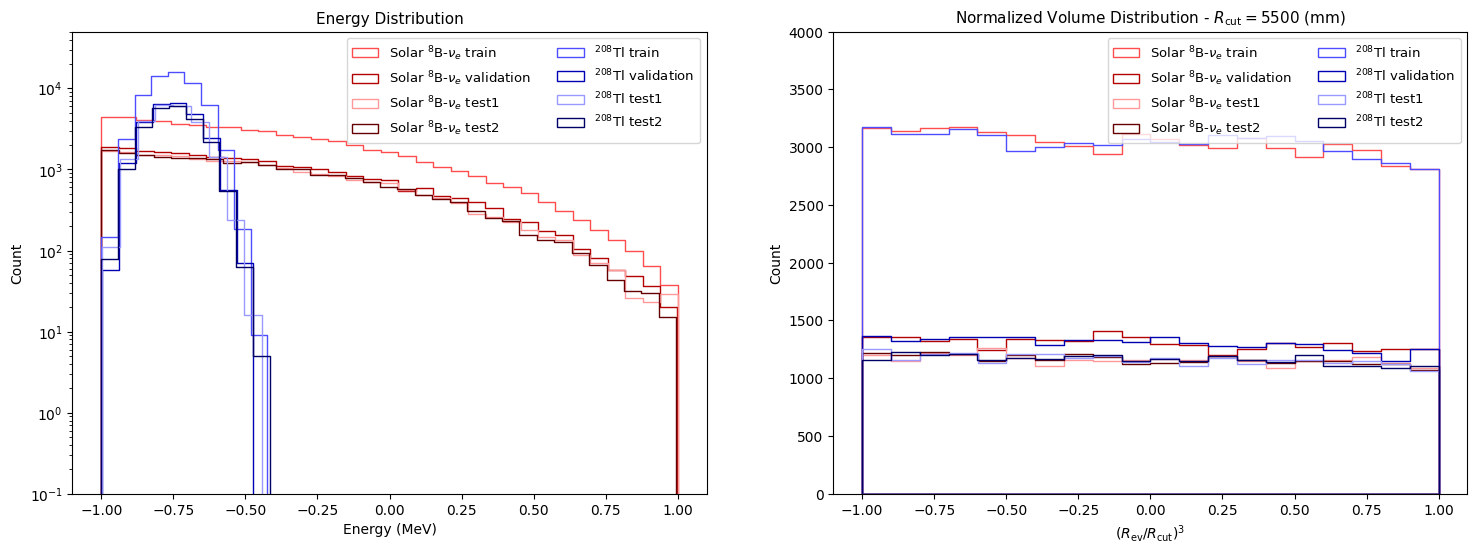

In [51]:
binwidth_en = 0.06
binwidth_rad = 0.1

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Plots
sn.histplot(energy_train1_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(energy_val_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ validation')
sn.histplot(energy_test1_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[2], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test1')
sn.histplot(energy_test2_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[3], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test2')
sn.histplot(energy_train1_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[0], element = 'step', alpha = 0, label = r'$^{208}$Tl train')
sn.histplot(energy_val_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[1], element = 'step', alpha = 0, label = r'$^{208}$Tl validation')
sn.histplot(energy_test1_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[2], element = 'step', alpha = 0, label = r'$^{208}$Tl test1')
sn.histplot(energy_test2_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[3], element = 'step', alpha = 0, label = r'$^{208}$Tl test2')

#Radial Plots
sn.histplot(position_train1_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(position_val_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ validation')
sn.histplot(position_test1_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[2], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test1')
sn.histplot(position_test2_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[3], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test2')
sn.histplot(position_train1_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = r'$^{208}$Tl train')
sn.histplot(position_val_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[1], element = 'step', alpha = 0, label = r'$^{208}$Tl validation')
sn.histplot(position_test1_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[2], element = 'step', alpha = 0, label = r'$^{208}$Tl test1')
sn.histplot(position_test2_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[3], element = 'step', alpha = 0, label = r'$^{208}$Tl test2')

axes[0].set_xlabel('Energy (MeV)')
axes[0].legend(loc='upper right', ncol = 2, fontsize = 9.5)
axes[0].set_title('Energy Distribution', fontsize = 11)
axes[0].set_yscale('log')
axes[0].set_ylim(0.1, 0.5e5)

axes[1].set_xlabel(r'$(R_\text{ev}/R_\text{cut})^{3}$')
axes[1].legend(loc='upper right', ncol = 2, fontsize = 9.5)
axes[1].set_title(r'Normalized Volume Distribution - $R_\text{cut} = $5500 (mm)', fontsize = 11)
#axes[1].set_yscale('log')
axes[1].set_ylim(0, 4000)

#plt.savefig('figs/Optimized Models/10x10/Std_Rad_Norm_Vol and Std_Scaler_default Solar Energy/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split/split_test_energy.png', format = 'png', bbox_inches = 'tight')
plt.show()

# Model Optimization

In [91]:
def create_OP_Model(trial):

    #To save memory
    clear_session()
    
    #Optimization of Hyperparameters

    #Image layers suggestions
    n_image_layers = trial.suggest_int('N_Image_layers', 1, 10)

    #Energy layers suggestions
    n_en_layers = trial.suggest_int('N_Energy_layers', 1, 3)

    #Radius Layers suggestions
    n_rad_layers = trial.suggest_int('N_Radius_layers', 1, 3)

    # Nº of neurons suggestion
    #Before Dropout Layers - before concatenate
    n_bdo_layers = trial.suggest_int('N_bdo_layers', 1, 3)

    #After Dropout Layers
    n_ado_layers = trial.suggest_int('N_ado_layers', 1, 3)

    #Learning Rate and Dropout rate
    lr_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    do_rate = trial.suggest_float('Drop_out_rate', 0, 0.7)

    #Number of neurons to be saved in each Optimized Layer
    n_units_image_ly = []
    n_units_en_ly = []
    n_units_rad_ly = []
    n_units_bdo_ly = []
    n_units_ado_ly = []

#-----------------------------------Arquitectura--------------------------------------------------------------------------
    #Input Layers
    #image
    image_dim = (10,10)
    input_im_shape = image_dim[0]*image_dim[1]
    input_image = Input(shape = (input_im_shape,), name = 'image_input')

    #Energy
    input_energy = Input(shape = (1,), name = 'energy_input')

    #Radius
    input_rad = Input(shape = (1,), name = 'radius_input')

    #Hidden Layers for Image (decreasing number of neurons)
    #first Image Hidden Layer
    n_neurons = trial.suggest_int('n_neurons_im_ly_0', 70, 90)
    image_ly = Dense(n_neurons, activation = 'gelu', name = 'im_ly_0')(input_image)
    for i in range(n_image_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, 70)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, n_units_image_ly[i-1])  #Garantiza que el numero de neuronas disminuye, o es el mismo, con un minimo de 50!
        n_units_image_ly.append(n_neurons)
            
        image_ly = Dense(n_neurons, activation = 'gelu', name = f'im_ly_{i+1}')(image_ly)

    #Hidden Layers for Energy
    #first energy Hidden Layer
    n_en_neurons = trial.suggest_int('n_neurons_en_ly_0', 50, 70)
    energy_ly = Dense(n_en_neurons, activation = 'gelu', name = 'en_ly_0')(input_energy)
    for i in range(n_en_layers):
        if i == 0:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, 50)
        else:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, n_units_en_ly[i-1])
        n_units_en_ly.append(n_en_neurons)

        energy_ly = Dense(n_en_neurons, activation = 'gelu', name = f'en_ly_{i+1}')(energy_ly)

    #Hidden Layers for Radius
    #first radial hidden layer
    n_rad_neurons = trial.suggest_int('n_neurons_rad_ly_0', 50, 70)
    radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = 'rad_ly_0')(input_rad)
    for i in range(n_rad_layers):
        if i == 0:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, 50)
        else:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, n_units_rad_ly[i-1])
        n_units_rad_ly.append(n_rad_neurons)

        radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = f'rad_ly_{i+1}')(radial_ly)

    #Concatenate info:
    x = concatenate([image_ly, input_energy, input_rad])

    #first hidden layer after concatenate: Maximum neurons = min(en_units) + min(rad_units) + min(im_units) of last layer
    n_neurons = trial.suggest_int('n_neurons_bdo_ly_0', 30, n_rad_neurons + n_en_neurons + n_neurons)
    x = Dense(n_neurons, activation = 'gelu', name = 'bdo_ly_0')(x)
    for i in range(n_bdo_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_units_bdo_ly[i-1])
        n_units_bdo_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i+1}')(x)

    #Dropout Layer
    x = Dropout(rate = do_rate)(x)

    for i in range(n_ado_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_units_ado_ly[i-1])
        n_units_ado_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'ado_ly_{i}')(x)
        
    output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

    model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ['AUC', 'accuracy'])

    return model

    #-------------------------------------------------------------------------------------------------------------

def objective(trial):

    model = create_OP_Model(trial)
    
    history = model.fit(x = {'image_input': pixel_train_transf, 'energy_input': energy_train_transf, 'radius_input': position_train_transf}, 
                    y = {'nu_predict':labels_train}, 
                    epochs = 150, 
                    batch_size = 300,
                    validation_split = 0.3,
                    #validation_data = ({'image_input': pixel_val.to_numpy(), 'energy_input': energy_val, 'radius_input': radi_val}, label_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 30, min_delta = 1e-2)],
                    shuffle = True)
    
    X_sig_pred = model.predict([pixel_test1_transf_sig, energy_test1_transf_sig, position_test1_transf_sig])
    X_bkg_pred = model.predict([pixel_test1_transf_bkg, energy_test1_transf_bkg, position_test1_transf_bkg])

    # Criterio de Optimización: 1) Disminuir error de predicción (BCE), 2) Aumentar AUC (probar)
    #1)BCE
    #BCE = tf.keras.losses.BinaryCrossentropy()

    #2)AUC
    x_pred = np.concatenate((X_sig_pred, X_bkg_pred))         #Predicted
    x_exp = np.concatenate((labels_test1_sig, labels_test1_bkg))  #expected

    # Classification overall Model
    fpr, tpr, thresholds = roc_curve(np.concatenate((x_exp[:,0], x_exp[:,1])), np.concatenate((x_pred[:,0], x_pred[:,1])))
    auc_val = auc(fpr, tpr)

    return auc_val
    
    
    #BCE_sig = BCE(label_sig_test, X_sig_pred)  #(x_real, x_predicted)
    #BCE_bkg = BCE(label_bkg_test, X_bkg_pred)

    # Usar ambos errores de predicción para minimizar el error de predicción (modulo del error)
    #BCE_mod = np.sqrt(BCE_sig**2 + BCE_bkg**2)
    
    #return BCE_mod

In [66]:
def create_OP_Model(trial):

    #To save memory
    clear_session()
    
    # Hidden Layers Optimization Range Settings: -----------------------------------------------------------------------

    #Image layers suggestions
    n_image_layers = trial.suggest_int('N_Image_layers', 1, 5)

    #Energy layers suggestions
    #n_en_layers = trial.suggest_int('N_Energy_layers', 1, 3)

    #Radius Layers suggestions
    #n_rad_layers = trial.suggest_int('N_Radius_layers', 1, 3)

    #Before Dropout Layers (BDO)
    n_bdo_layers = trial.suggest_int('N_bdo_layers', 1, 5)

    #After Dropout (ADO) Layers
    n_ado_layers = trial.suggest_int('N_ado_layers', 1, 5)

    #Adam Optimizer Hyperparams: -------------------------------------------------------------------------------------
    #Learning Rate
    lr_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    #Momentum estimators beta_1 (mean) and beta_2 (variance)
    beta_1 = trial.suggest_float('momentum_beta_1', 0.8, 0.95)
    beta_2 = trial.suggest_float('momentum_beta_2', 0.98, 0.999)

    #Dropout rate: ----------------------------------------------------------------------------------------------------
    do_rate = trial.suggest_float('Drop_out_rate', 0, 0.7)

    #lists with the number of neurons to be saved in each Optimized Layer
    n_units_image_ly = []
    #n_units_en_ly = []
    #n_units_rad_ly = []
    n_units_bdo_ly = []
    n_units_ado_ly = []

#-----------------------------------Architecture and Nº Neurons Suggestion---------------------------------------------
    #Input Layers
    # Image
    image_dim = (10,10)
    input_im_shape = image_dim[0]*image_dim[1]
    input_image = Input(shape = (input_im_shape,), name = 'image_input')

    #Energy
    input_energy = Input(shape = (1,), name = 'energy_input')

    #Radius
    input_position = Input(shape = (1,), name = 'position_input')

    #One Hidden Layers for Energy with only one neuron
    n_energy_neurons = 1
    energy_ly = Dense(n_energy_neurons, activation = 'gelu', name = 'en_ly_0')(input_energy)
    
    #One Hidden Layers for Position information with only one neuron
    n_position_neurons = 1
    position_ly = Dense(n_position_neurons, activation = 'gelu', name = 'pos_ly_0')(input_position)

    #Hidden Layers for pixels values with decreasing number of neurons:
    n_imag_neurons = trial.suggest_int('n_neurons_im_ly_0', 80, 90)
    n_neurons_image_last_ly = 30  #Nº of minimum neurons in the last hidden layer of the input image pixel values
    image_ly = Dense(n_imag_neurons, activation = 'gelu', name = 'im_ly_0')(input_image) #first Image Hidden Layer
    for i in range(n_image_layers):
        if i == 0:
            n_imag_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 60, 80)
        else:
            n_imag_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', n_neurons_image_last_ly, n_units_image_ly[i-1])  #Garantiza que el numero de neuronas disminuye, o es el mismo, con un minimo de n_neurons_image_last_ly!
        n_units_image_ly.append(n_imag_neurons)
            
        image_ly = Dense(n_imag_neurons, activation = 'gelu', name = f'im_ly_{i+1}')(image_ly)

    #Concatenate layer -------------------------------------------
    
    x = concatenate([image_ly, energy_ly, position_ly])

    #bdo layers ---------------------------------------------------
    #first hidden layer after concatenate: Maximum neurons = min(en_units) + min(rad_units) + min(im_units) of last layer
    n_neurons_bdo_last_ly = 22  #Nº of minimum neurons in the last bdo hidden layer
    n_neurons = trial.suggest_int('n_neurons_bdo_ly_0', n_units_image_ly[-1], n_imag_neurons + n_position_neurons + n_energy_neurons) #suggest a Nº of neurons between [last_neurons_imag_ly, sum of last_imag_ly_neurons + 2 (from energy + position)]
    x = Dense(n_neurons, activation = 'gelu', name = 'bdo_ly_0')(x)
    for i in range(n_bdo_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', n_neurons_bdo_last_ly, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', n_neurons_bdo_last_ly, n_units_bdo_ly[i-1])
        n_units_bdo_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i+1}')(x)

    #Dropout Layer -----------------------------------------------
    x = Dropout(rate = do_rate)(x)

    #ado layers --------------------------------------------------
    n_neurons_ado_last_ly = 5  # Nº of minimum neurons in the last ado hidden layer
    for i in range(n_ado_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', n_neurons_ado_last_ly, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', n_neurons_ado_last_ly, n_units_ado_ly[i-1])
        n_units_ado_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'ado_ly_{i}')(x)
        
    output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

    model = Model(inputs = [input_image, input_energy, input_position], outputs = output_layer)

    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate, beta_1 = beta_1, beta_2 = beta_2),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ['AUC', 'accuracy'])

    return model

    #-------------------------------------------------------------------------------------------------------------

def objective(trial):

    model = create_OP_Model(trial)
    
    history = model.fit(x = {'image_input': pixel_train_transf, 'energy_input': energy_train_transf, 'position_input': position_train_transf}, 
                    y = {'nu_predict':labels_train}, 
                    epochs = 200, 
                    batch_size = 1000,
                    validation_data=([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 15, min_delta = 1e-3, monitor="val_AUC")],
                    shuffle = True)
    
    X_sig_pred = model.predict([pixel_test1_transf_sig, energy_test1_transf_sig, position_test1_transf_sig])
    X_bkg_pred = model.predict([pixel_test1_transf_bkg, energy_test1_transf_bkg, position_test1_transf_bkg])

    # Criterio de Optimización: 1) Disminuir error de predicción (BCE), 2) Aumentar AUC (probar)
    #1)BCE
    #BCE = tf.keras.losses.BinaryCrossentropy()

    #2)AUC
    x_pred = np.concatenate((X_sig_pred, X_bkg_pred))             # Predicted
    x_exp = np.concatenate((labels_test1_sig, labels_test1_bkg))  # Expected

    # Classification overall Model
    fpr, tpr, thresholds = roc_curve(np.concatenate((x_exp[:,0], x_exp[:,1])), np.concatenate((x_pred[:,0], x_pred[:,1])))
    auc_val = auc(fpr, tpr)

    return auc_val
    
    
    #BCE_sig = BCE(label_sig_test, X_sig_pred)  #(x_real, x_predicted)
    #BCE_bkg = BCE(label_bkg_test, X_bkg_pred)

    # Usar ambos errores de predicción para minimizar el error de predicción (modulo del error)
    #BCE_mod = np.sqrt(BCE_sig**2 + BCE_bkg**2)
    
    #return BCE_mod

In [52]:
def create_OP_Model(trial):

    #To save memory
    clear_session()
    
    # Hidden Layers Optimization Range Settings: -----------------------------------------------------------------------

    #Image layers suggestions
    n_image_layers = trial.suggest_int('N_Image_layers', 1, 10)

    #Energy layers suggestions
    #n_en_layers = trial.suggest_int('N_Energy_layers', 1, 3)

    #Radius Layers suggestions
    #n_rad_layers = trial.suggest_int('N_Radius_layers', 1, 3)

    #Before Dropout Layers (BDO)
    n_bdo_layers = trial.suggest_int('N_bdo_layers', 1, 10)

    #After Dropout (ADO) Layers
    n_ado_layers = trial.suggest_int('N_ado_layers', 1, 10)

    #Adam Optimizer Hyperparams: -------------------------------------------------------------------------------------
    #Learning Rate
    lr_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3)
    #Momentum estimators beta_1 (mean) and beta_2 (variance)
    #beta_1 = trial.suggest_float('momentum_beta_1', 0.8, 0.95)
    #beta_2 = trial.suggest_float('momentum_beta_2', 0.98, 0.999)

    #Dropout rate: ----------------------------------------------------------------------------------------------------
    do_rate = trial.suggest_float('Drop_out_rate', 0, 0.7)

    #lists with the number of neurons to be saved in each Optimized Layer
    n_units_image_ly = []
    #n_units_en_ly = []
    #n_units_rad_ly = []
    n_units_bdo_ly = []
    n_units_ado_ly = []

#-----------------------------------Architecture and Nº Neurons Suggestion--------------------------------------------------------
    
    #Input Layers ------------------------------------------------------------------------------------------------
    # Image Input Layer
    image_dim = (10,10)
    input_im_shape = image_dim[0]*image_dim[1]
    input_image = Input(shape = (input_im_shape,), name = 'image_input')

    #Energy Input Layer
    input_energy = Input(shape = (1,), name = 'energy_input')

    #Position Input Layer
    input_position = Input(shape = (1,), name = 'position_input')

    #Hidden Layers for pixels values with decreasing number of neurons: ----------------------------------------------
    n_neurons_image_first_ly = trial.suggest_int('n_neurons_1st_image_hidden_ly', 80, 95) #Nº of maximum neurons in the first hidden layer of the input image pixel values
    n_neurons_image_last_ly = trial.suggest_int('n_neurons_last_image_hidden_ly', 20, 30)  #Nº of minimum neurons in the last hidden layer of the input image pixel values
    for i in range(n_image_layers):
        if i == 0:
            n_imag_neurons = trial.suggest_int(f'n_neurons_im_ly_{i}', n_neurons_image_last_ly, n_neurons_image_first_ly) #first Image Hidden Layer with a maximum of
            image_ly = Dense(n_imag_neurons, activation = 'gelu', name = f'im_ly_{i}')(input_image)
        else:
            n_imag_neurons = trial.suggest_int(f'n_neurons_im_ly_{i}', n_neurons_image_last_ly, n_units_image_ly[i-1])  #Garantiza que el numero de neuronas disminuye, o es el mismo, con un minimo de n_neurons_image_last_ly!
            image_ly = Dense(n_imag_neurons, activation = 'gelu', name = f'im_ly_{i}')(image_ly)
        n_units_image_ly.append(n_imag_neurons)

    #Concatenate layer --------------------------------------------------------------------------------
    x = concatenate([image_ly, input_energy, input_position])
    
    # Before-Drop-Out layers ----------------------------------------------------------------------------------------
    n_neurons_bdo_last_ly = trial.suggest_int('n_neurons_last_bdo_hidden_ly', n_units_image_ly[-1] - 10, n_units_image_ly[-1])  #Nº of minimum neurons in the last BDO hidden layer as function of the neurons in the image_last_ly
    for i in range(n_bdo_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i}', n_neurons_bdo_last_ly, n_units_image_ly[-1] + 2)  #Nº max neurons = neurons_last_imag_ly + 2 (energy + position)
            x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i}')(x) # 1st hidden layer after concatenate: Maximum neurons =  min(imag_units) of last layer + 2 units (energy and position)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i}', n_neurons_bdo_last_ly, n_units_bdo_ly[i-1])
            x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i}')(x)
        n_units_bdo_ly.append(n_neurons)
        

    # Dropout Layer ---------------------------------------------------------
    x = Dropout(rate = do_rate)(x)

    # After-Drop-Out layers --------------------------------------------------
    n_neurons_ado_last_ly = trial.suggest_int('n_neurons_last_ado_hidden_ly', 4, n_units_bdo_ly[-1])  #Nº of minimum neurons in the last ADO hidden layer as function of the neurons in the bdo_last_ly
    for i in range(n_ado_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', n_neurons_ado_last_ly, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', n_neurons_ado_last_ly, n_units_ado_ly[i-1])
        n_units_ado_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'ado_ly_{i}')(x)

    # Output Layer -------------------------------------------------------------    
    output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)
    
    #--------------------------------------------------------------------------------------------------------------------------------------------------

    model = Model(inputs = [input_image, input_energy, input_position], outputs = output_layer)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ['AUC', 'accuracy'])

    return model

    #-------------------------------------------------------------------------------------------------------------

def objective(trial):

    model = create_OP_Model(trial)
    
    history = model.fit(x = {'image_input': pixel_train1_transf, 'energy_input': energy_train1_transf, 'position_input': position_train1_transf}, 
                    y = {'nu_predict':labels_train1}, 
                    epochs = 200, 
                    batch_size = 2000,
                    validation_data=([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 15, min_delta = 1e-3, monitor="val_loss")],
                    shuffle = True)
    
    X_sig_pred = model.predict([pixel_test1_transf_sig, energy_test1_transf_sig, position_test1_transf_sig])
    X_bkg_pred = model.predict([pixel_test1_transf_bkg, energy_test1_transf_bkg, position_test1_transf_bkg])

    # Criterio de Optimización: 1) Disminuir error de predicción (BCE), 2) Aumentar AUC (probar)
    #1)BCE
    #BCE = tf.keras.losses.BinaryCrossentropy()

    #2)AUC
    x_pred = np.concatenate((X_sig_pred, X_bkg_pred))             # Predicted
    x_exp = np.concatenate((labels_test1_sig, labels_test1_bkg))  # Expected

    # Classification overall Model
    fpr, tpr, thresholds = roc_curve(np.concatenate((x_exp[:,0], x_exp[:,1])), np.concatenate((x_pred[:,0], x_pred[:,1])))
    auc_val = auc(fpr, tpr)

    return auc_val
    
    
    #BCE_sig = BCE(label_sig_test, X_sig_pred)  #(x_real, x_predicted)
    #BCE_bkg = BCE(label_bkg_test, X_bkg_pred)

    # Usar ambos errores de predicción para minimizar el error de predicción (modulo del error)
    #BCE_mod = np.sqrt(BCE_sig**2 + BCE_bkg**2)
    
    #return BCE_mod

In [53]:
study = optuna.create_study(directions = ["maximize"])
study.optimize(objective, n_trials = 50)
best_trial = study.best_trial

print("Best Hyperparms.:", study.best_trial.params) #To see the best 
print("Value: ", best_trial.value)

[I 2025-07-08 21:50:06,790] A new study created in memory with name: no-name-64466405-55eb-4bd7-ada8-9532e76115dd


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - AUC: 0.5000 - accuracy: 0.4993 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5542 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.5003 - accuracy: 0.5073 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.5000 - accuracy: 0.4966 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.6279 - accuracy: 0.6000 - loss: 0.6668 - val_AUC: 0.8231 - val_accuracy: 0.7501 - val_loss: 0.4793
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8362 - accuracy: 0.7605 - loss: 0.4723 - val_AUC: 0.8679 - val_accuracy: 0.7697 - val_loss: 0.4444
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8597 - accuracy: 0.7763 - loss: 0.4469 - val_AUC: 0.8778 - val_accuracy: 0.8072 - val_loss: 0.4199
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 21:50:52,195] Trial 0 finished with value: 0.8892351879147908 and parameters: {'N_Image_layers': 5, 'N_bdo_layers': 8, 'N_ado_layers': 9, 'learning_rate': 0.0006987658450381683, 'Drop_out_rate': 0.4890752058607426, 'n_neurons_1st_image_hidden_ly': 86, 'n_neurons_last_image_hidden_ly': 26, 'n_neurons_im_ly_0': 32, 'n_neurons_im_ly_1': 26, 'n_neurons_im_ly_2': 26, 'n_neurons_im_ly_3': 26, 'n_neurons_im_ly_4': 26, 'n_neurons_last_bdo_hidden_ly': 20, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 25, 'n_neurons_bdo_ly_2': 24, 'n_neurons_bdo_ly_3': 20, 'n_neurons_bdo_ly_4': 20, 'n_neurons_bdo_ly_5': 20, 'n_neurons_bdo_ly_6': 20, 'n_neurons_bdo_ly_7': 20, 'n_neurons_last_ado_hidden_ly': 12, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 15, 'n_neurons_ado_ly_2': 13, 'n_neurons_ado_ly_3': 12, 'n_neurons_ado_ly_4': 12, 'n_neurons_ado_ly_5': 12, 'n_neurons_ado_ly_6': 12, 'n_neurons_ado_ly_7': 12, 'n_neurons_ado_ly_8': 12}. Best is trial 0 with value: 0.8892351879147908.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - AUC: 0.5000 - accuracy: 0.5288 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.6353 - val_loss: 0.6930
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5253 - accuracy: 0.5665 - loss: 0.6927 - val_AUC: 0.5635 - val_accuracy: 0.5010 - val_loss: 0.6884
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5827 - accuracy: 0.5426 - loss: 0.6856 - val_AUC: 0.6548 - val_accuracy: 0.6372 - val_loss: 0.6704
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6751 - accuracy: 0.6703 - loss: 0.6700 - val_AUC: 0.6901 - val_accuracy: 0.7158 - val_loss: 0.6494
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7124 - accuracy: 0.7209 - loss: 0.6483 - val_AUC: 0.7304 - val_accuracy: 0.7561 - val_loss: 0.6080
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7592 - accuracy: 0.7425 - loss: 0.6019 - val_AUC: 0.8579 - val_accuracy: 0.7635 - val_loss: 0.5008
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

[I 2025-07-08 21:51:42,945] Trial 1 finished with value: 0.8891820569049305 and parameters: {'N_Image_layers': 4, 'N_bdo_layers': 8, 'N_ado_layers': 2, 'learning_rate': 0.00012308243229325214, 'Drop_out_rate': 0.5095182890348532, 'n_neurons_1st_image_hidden_ly': 92, 'n_neurons_last_image_hidden_ly': 21, 'n_neurons_im_ly_0': 43, 'n_neurons_im_ly_1': 33, 'n_neurons_im_ly_2': 24, 'n_neurons_im_ly_3': 21, 'n_neurons_last_bdo_hidden_ly': 19, 'n_neurons_bdo_ly_0': 22, 'n_neurons_bdo_ly_1': 20, 'n_neurons_bdo_ly_2': 19, 'n_neurons_bdo_ly_3': 19, 'n_neurons_bdo_ly_4': 19, 'n_neurons_bdo_ly_5': 19, 'n_neurons_bdo_ly_6': 19, 'n_neurons_bdo_ly_7': 19, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 13}. Best is trial 0 with value: 0.8892351879147908.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - AUC: 0.4996 - accuracy: 0.5045 - loss: 0.6931 - val_AUC: 0.5819 - val_accuracy: 0.5153 - val_loss: 0.6905
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.6640 - accuracy: 0.6296 - loss: 0.6608 - val_AUC: 0.8129 - val_accuracy: 0.7466 - val_loss: 0.4927
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8213 - accuracy: 0.7523 - loss: 0.4861 - val_AUC: 0.8458 - val_accuracy: 0.7512 - val_loss: 0.4742
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8532 - accuracy: 0.7732 - loss: 0.4564 - val_AUC: 0.8773 - val_accuracy: 0.8080 - val_loss: 0.4212
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8729 - accuracy: 0.7951 - loss: 0.4290 - val_AUC: 0.8791 - val_accuracy: 0.8087 - val_loss: 0.4175
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8791 - accuracy: 0.8011 - loss: 0.4202 - val_AUC: 0.8844 - val_accuracy: 0.8150 - val_loss: 0.4098
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 21:52:13,623] Trial 2 finished with value: 0.8833384862065322 and parameters: {'N_Image_layers': 2, 'N_bdo_layers': 6, 'N_ado_layers': 8, 'learning_rate': 0.0005049017378209782, 'Drop_out_rate': 0.3125632962962593, 'n_neurons_1st_image_hidden_ly': 94, 'n_neurons_last_image_hidden_ly': 20, 'n_neurons_im_ly_0': 67, 'n_neurons_im_ly_1': 39, 'n_neurons_last_bdo_hidden_ly': 34, 'n_neurons_bdo_ly_0': 38, 'n_neurons_bdo_ly_1': 37, 'n_neurons_bdo_ly_2': 35, 'n_neurons_bdo_ly_3': 35, 'n_neurons_bdo_ly_4': 34, 'n_neurons_bdo_ly_5': 34, 'n_neurons_last_ado_hidden_ly': 20, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 20, 'n_neurons_ado_ly_3': 20, 'n_neurons_ado_ly_4': 20, 'n_neurons_ado_ly_5': 20, 'n_neurons_ado_ly_6': 20, 'n_neurons_ado_ly_7': 20}. Best is trial 0 with value: 0.8892351879147908.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.5357 - accuracy: 0.5305 - loss: 0.6920 - val_AUC: 0.6387 - val_accuracy: 0.6078 - val_loss: 0.6881
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.5977 - accuracy: 0.5739 - loss: 0.6869 - val_AUC: 0.7163 - val_accuracy: 0.6669 - val_loss: 0.6761
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6384 - accuracy: 0.6031 - loss: 0.6754 - val_AUC: 0.7302 - val_accuracy: 0.6734 - val_loss: 0.6580
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6686 - accuracy: 0.6233 - loss: 0.6605 - val_AUC: 0.7510 - val_accuracy: 0.7028 - val_loss: 0.6367
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6965 - accuracy: 0.6437 - loss: 0.6442 - val_AUC: 0.7674 - val_accuracy: 0.7197 - val_loss: 0.6132
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7225 - accuracy: 0.6657 - loss: 0.6241 - val_AUC: 0.7797 - val_accuracy: 0.7358 - val_loss: 0.5878
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms

[I 2025-07-08 21:53:02,160] Trial 3 finished with value: 0.8851165041191391 and parameters: {'N_Image_layers': 6, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.00019731573569147968, 'Drop_out_rate': 0.6261458172892288, 'n_neurons_1st_image_hidden_ly': 86, 'n_neurons_last_image_hidden_ly': 22, 'n_neurons_im_ly_0': 35, 'n_neurons_im_ly_1': 31, 'n_neurons_im_ly_2': 25, 'n_neurons_im_ly_3': 22, 'n_neurons_im_ly_4': 22, 'n_neurons_im_ly_5': 22, 'n_neurons_last_bdo_hidden_ly': 14, 'n_neurons_bdo_ly_0': 20, 'n_neurons_last_ado_hidden_ly': 17, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 17, 'n_neurons_ado_ly_2': 17}. Best is trial 0 with value: 0.8892351879147908.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.5000 - accuracy: 0.4955 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5000 - accuracy: 0.5013 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5000 - accuracy: 0.5014 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5000 - accuracy: 0.5090 - loss: 0.6931 - val_AUC: 0.5007 - val_accuracy: 0.7188 - val_loss: 0.6926
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.6056 - accuracy: 0.6101 - loss: 0.6901 - val_AUC: 0.8012 - val_accuracy: 0.7527 - val_loss: 0.6579
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7246 - accuracy: 0.6701 - loss: 0.6461 - val_AUC: 0.8072 - val_accuracy: 0.7668 - val_loss: 0.5256
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

[I 2025-07-08 21:53:42,664] Trial 4 finished with value: 0.8860511896764218 and parameters: {'N_Image_layers': 4, 'N_bdo_layers': 3, 'N_ado_layers': 9, 'learning_rate': 0.00014820931231997175, 'Drop_out_rate': 0.2129514902146685, 'n_neurons_1st_image_hidden_ly': 87, 'n_neurons_last_image_hidden_ly': 22, 'n_neurons_im_ly_0': 43, 'n_neurons_im_ly_1': 35, 'n_neurons_im_ly_2': 28, 'n_neurons_im_ly_3': 27, 'n_neurons_last_bdo_hidden_ly': 17, 'n_neurons_bdo_ly_0': 29, 'n_neurons_bdo_ly_1': 22, 'n_neurons_bdo_ly_2': 21, 'n_neurons_last_ado_hidden_ly': 10, 'n_neurons_ado_ly_0': 10, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10, 'n_neurons_ado_ly_3': 10, 'n_neurons_ado_ly_4': 10, 'n_neurons_ado_ly_5': 10, 'n_neurons_ado_ly_6': 10, 'n_neurons_ado_ly_7': 10, 'n_neurons_ado_ly_8': 10}. Best is trial 0 with value: 0.8892351879147908.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.5665 - accuracy: 0.5555 - loss: 0.6831 - val_AUC: 0.7775 - val_accuracy: 0.7328 - val_loss: 0.5510
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7879 - accuracy: 0.7277 - loss: 0.5278 - val_AUC: 0.8568 - val_accuracy: 0.7636 - val_loss: 0.4660
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8476 - accuracy: 0.7612 - loss: 0.4670 - val_AUC: 0.8657 - val_accuracy: 0.7834 - val_loss: 0.4395
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8641 - accuracy: 0.7865 - loss: 0.4427 - val_AUC: 0.8761 - val_accuracy: 0.8019 - val_loss: 0.4230
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8675 - accuracy: 0.7914 - loss: 0.4378 - val_AUC: 0.8786 - val_accuracy: 0.8045 - val_loss: 0.4202
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8764 - accuracy: 0.7999 - loss: 0.4249 - val_AUC: 0.8795 - val_accuracy: 0.8041 - val_loss: 0.4199
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

[I 2025-07-08 21:54:24,234] Trial 5 finished with value: 0.8998091566307075 and parameters: {'N_Image_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 5, 'learning_rate': 0.0008722748338848168, 'Drop_out_rate': 0.44015464421960426, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 20, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 43, 'n_neurons_im_ly_2': 41, 'n_neurons_last_bdo_hidden_ly': 37, 'n_neurons_bdo_ly_0': 43, 'n_neurons_bdo_ly_1': 42, 'n_neurons_last_ado_hidden_ly': 22, 'n_neurons_ado_ly_0': 34, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 22, 'n_neurons_ado_ly_3': 22, 'n_neurons_ado_ly_4': 22}. Best is trial 5 with value: 0.8998091566307075.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - AUC: 0.4998 - accuracy: 0.4969 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.5303 - accuracy: 0.5135 - loss: 0.6922 - val_AUC: 0.7449 - val_accuracy: 0.7527 - val_loss: 0.6420
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.7565 - accuracy: 0.6967 - loss: 0.5779 - val_AUC: 0.8797 - val_accuracy: 0.8128 - val_loss: 0.4226
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8591 - accuracy: 0.7830 - loss: 0.4467 - val_AUC: 0.8782 - val_accuracy: 0.8056 - val_loss: 0.4205
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8674 - accuracy: 0.7890 - loss: 0.4370 - val_AUC: 0.8820 - val_accuracy: 0.8151 - val_loss: 0.4136
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8703 - accuracy: 0.7916 - loss: 0.4331 - val_AUC: 0.8816 - val_accuracy: 0.8137 - val_loss: 0.4135
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 21:55:39,902] Trial 6 finished with value: 0.8991877301992155 and parameters: {'N_Image_layers': 6, 'N_bdo_layers': 3, 'N_ado_layers': 10, 'learning_rate': 0.0004358569746744858, 'Drop_out_rate': 0.5650520844323111, 'n_neurons_1st_image_hidden_ly': 87, 'n_neurons_last_image_hidden_ly': 27, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 47, 'n_neurons_im_ly_3': 43, 'n_neurons_im_ly_4': 35, 'n_neurons_im_ly_5': 31, 'n_neurons_last_bdo_hidden_ly': 23, 'n_neurons_bdo_ly_0': 23, 'n_neurons_bdo_ly_1': 23, 'n_neurons_bdo_ly_2': 23, 'n_neurons_last_ado_hidden_ly': 20, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 20, 'n_neurons_ado_ly_2': 20, 'n_neurons_ado_ly_3': 20, 'n_neurons_ado_ly_4': 20, 'n_neurons_ado_ly_5': 20, 'n_neurons_ado_ly_6': 20, 'n_neurons_ado_ly_7': 20, 'n_neurons_ado_ly_8': 20, 'n_neurons_ado_ly_9': 20}. Best is trial 5 with value: 0.8998091566307075.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - AUC: 0.5310 - accuracy: 0.5203 - loss: 0.6914 - val_AUC: 0.7188 - val_accuracy: 0.6453 - val_loss: 0.6510
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.7424 - accuracy: 0.6956 - loss: 0.6141 - val_AUC: 0.8254 - val_accuracy: 0.7409 - val_loss: 0.4914
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8233 - accuracy: 0.7481 - loss: 0.4932 - val_AUC: 0.8618 - val_accuracy: 0.7631 - val_loss: 0.4513
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8457 - accuracy: 0.7650 - loss: 0.4650 - val_AUC: 0.8610 - val_accuracy: 0.7602 - val_loss: 0.4530
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8543 - accuracy: 0.7759 - loss: 0.4545 - val_AUC: 0.8610 - val_accuracy: 0.7591 - val_loss: 0.4548
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8569 - accuracy: 0.7781 - loss: 0.4505 - val_AUC: 0.8684 - val_accuracy: 0.7824 - val_loss: 0.4348
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10

[I 2025-07-08 21:55:59,556] Trial 7 finished with value: 0.8455497460496599 and parameters: {'N_Image_layers': 3, 'N_bdo_layers': 7, 'N_ado_layers': 3, 'learning_rate': 0.000777610228200327, 'Drop_out_rate': 0.6970747532200512, 'n_neurons_1st_image_hidden_ly': 90, 'n_neurons_last_image_hidden_ly': 22, 'n_neurons_im_ly_0': 24, 'n_neurons_im_ly_1': 24, 'n_neurons_im_ly_2': 22, 'n_neurons_last_bdo_hidden_ly': 20, 'n_neurons_bdo_ly_0': 20, 'n_neurons_bdo_ly_1': 20, 'n_neurons_bdo_ly_2': 20, 'n_neurons_bdo_ly_3': 20, 'n_neurons_bdo_ly_4': 20, 'n_neurons_bdo_ly_5': 20, 'n_neurons_bdo_ly_6': 20, 'n_neurons_last_ado_hidden_ly': 18, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 19, 'n_neurons_ado_ly_2': 18}. Best is trial 5 with value: 0.8998091566307075.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.5463 - accuracy: 0.5462 - loss: 0.6898 - val_AUC: 0.7568 - val_accuracy: 0.7242 - val_loss: 0.6664
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6521 - accuracy: 0.6101 - loss: 0.6626 - val_AUC: 0.7408 - val_accuracy: 0.6520 - val_loss: 0.6191
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7238 - accuracy: 0.6633 - loss: 0.6165 - val_AUC: 0.7923 - val_accuracy: 0.7464 - val_loss: 0.5645
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.7718 - accuracy: 0.7145 - loss: 0.5739 - val_AUC: 0.7993 - val_accuracy: 0.7474 - val_loss: 0.5359
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7899 - accuracy: 0.7359 - loss: 0.5470 - val_AUC: 0.8044 - val_accuracy: 0.7578 - val_loss: 0.5190
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8014 - accuracy: 0.7473 - loss: 0.5261 - val_AUC: 0.8061 - val_accuracy: 0.7456 - val_loss: 0.5053
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms

[I 2025-07-08 21:56:39,868] Trial 8 finished with value: 0.9005825819418104 and parameters: {'N_Image_layers': 5, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0006223561798056558, 'Drop_out_rate': 0.6099467610325138, 'n_neurons_1st_image_hidden_ly': 91, 'n_neurons_last_image_hidden_ly': 25, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 38, 'n_neurons_im_ly_2': 30, 'n_neurons_im_ly_3': 25, 'n_neurons_im_ly_4': 25, 'n_neurons_last_bdo_hidden_ly': 22, 'n_neurons_bdo_ly_0': 23, 'n_neurons_last_ado_hidden_ly': 13, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 19}. Best is trial 8 with value: 0.9005825819418104.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 0.5000 - accuracy: 0.4917 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5132 - val_loss: 0.6930
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.5943 - accuracy: 0.5849 - loss: 0.6766 - val_AUC: 0.8082 - val_accuracy: 0.7399 - val_loss: 0.4984
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8620 - accuracy: 0.7829 - loss: 0.4488 - val_AUC: 0.8879 - val_accuracy: 0.8154 - val_loss: 0.4057
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8887 - accuracy: 0.8153 - loss: 0.4035 - val_AUC: 0.8876 - val_accuracy: 0.8141 - val_loss: 0.4054
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8901 - accuracy: 0.8164 - loss: 0.4007 - val_AUC: 0.8863 - val_accuracy: 0.8120 - val_loss: 0.4075
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8893 - accuracy: 0.8151 - loss: 0.4019 - val_AUC: 0.8925 - val_accuracy: 0.8193 - val_loss: 0.3961
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 21:57:35,952] Trial 9 finished with value: 0.9004679169847567 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 6, 'N_ado_layers': 7, 'learning_rate': 0.0007790177667150337, 'Drop_out_rate': 0.019939856051222858, 'n_neurons_1st_image_hidden_ly': 93, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 46, 'n_neurons_im_ly_4': 43, 'n_neurons_im_ly_5': 28, 'n_neurons_im_ly_6': 28, 'n_neurons_im_ly_7': 28, 'n_neurons_im_ly_8': 28, 'n_neurons_im_ly_9': 28, 'n_neurons_last_bdo_hidden_ly': 26, 'n_neurons_bdo_ly_0': 30, 'n_neurons_bdo_ly_1': 27, 'n_neurons_bdo_ly_2': 27, 'n_neurons_bdo_ly_3': 27, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_last_ado_hidden_ly': 14, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 15, 'n_neurons_ado_ly_2': 14, 'n_neurons_ado_ly_3': 14, 'n_neurons_ado_ly_4': 14, 'n_neurons_ado_ly_5': 14, 'n_neurons_ado_ly_6': 14}. Best is trial 8 with value: 0.90

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5366 - accuracy: 0.5069 - loss: 0.6913 - val_AUC: 0.7339 - val_accuracy: 0.7549 - val_loss: 0.6039
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.7400 - accuracy: 0.7219 - loss: 0.5876 - val_AUC: 0.8327 - val_accuracy: 0.7666 - val_loss: 0.4773
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8357 - accuracy: 0.7637 - loss: 0.4727 - val_AUC: 0.8700 - val_accuracy: 0.7923 - val_loss: 0.4366
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8748 - accuracy: 0.8086 - loss: 0.4302 - val_AUC: 0.8859 - val_accuracy: 0.8164 - val_loss: 0.4082
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8841 - accuracy: 0.8147 - loss: 0.4110 - val_AUC: 0.8875 - val_accuracy: 0.8130 - val_loss: 0.4069
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8844 - accuracy: 0.8140 - loss: 0.4105 - val_AUC: 0.8915 - val_accuracy: 0.8192 - val_loss: 0.4003
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 21:58:24,511] Trial 10 finished with value: 0.9012526573231024 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 10, 'N_ado_layers': 1, 'learning_rate': 0.0009746869425936555, 'Drop_out_rate': 0.29081815845936065, 'n_neurons_1st_image_hidden_ly': 82, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 59, 'n_neurons_im_ly_1': 48, 'n_neurons_im_ly_2': 34, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_bdo_ly_6': 26, 'n_neurons_bdo_ly_7': 26, 'n_neurons_bdo_ly_8': 26, 'n_neurons_bdo_ly_9': 25, 'n_neurons_last_ado_hidden_ly': 5, 'n_neurons_ado_ly_0': 6}. Best is trial 10 with value: 0.9012526573231024.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - AUC: 0.5094 - accuracy: 0.5134 - loss: 0.6928 - val_AUC: 0.7123 - val_accuracy: 0.6360 - val_loss: 0.6498
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8028 - accuracy: 0.7295 - loss: 0.5474 - val_AUC: 0.8713 - val_accuracy: 0.7688 - val_loss: 0.4401
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8679 - accuracy: 0.7816 - loss: 0.4379 - val_AUC: 0.8787 - val_accuracy: 0.8139 - val_loss: 0.4205
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8767 - accuracy: 0.8084 - loss: 0.4242 - val_AUC: 0.8811 - val_accuracy: 0.8173 - val_loss: 0.4166
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8773 - accuracy: 0.8120 - loss: 0.4231 - val_AUC: 0.8840 - val_accuracy: 0.8191 - val_loss: 0.4141
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8804 - accuracy: 0.8158 - loss: 0.4187 - val_AUC: 0.8841 - val_accuracy: 0.8186 - val_loss: 0.4130
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 21:59:23,054] Trial 11 finished with value: 0.9019298955341722 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 10, 'N_ado_layers': 1, 'learning_rate': 0.0009621059817850647, 'Drop_out_rate': 0.20758449254959133, 'n_neurons_1st_image_hidden_ly': 80, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 57, 'n_neurons_im_ly_1': 49, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_bdo_ly_6': 26, 'n_neurons_bdo_ly_7': 26, 'n_neurons_bdo_ly_8': 26, 'n_neurons_bdo_ly_9': 25, 'n_neurons_last_ado_hidden_ly': 5, 'n_neurons_ado_ly_0': 6}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 0.5357 - accuracy: 0.5171 - loss: 0.6904 - val_AUC: 0.7960 - val_accuracy: 0.7571 - val_loss: 0.5137
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8300 - accuracy: 0.7613 - loss: 0.4794 - val_AUC: 0.8750 - val_accuracy: 0.7700 - val_loss: 0.4245
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8720 - accuracy: 0.7847 - loss: 0.4296 - val_AUC: 0.8793 - val_accuracy: 0.8163 - val_loss: 0.4203
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8745 - accuracy: 0.8095 - loss: 0.4269 - val_AUC: 0.8802 - val_accuracy: 0.8181 - val_loss: 0.4180
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8786 - accuracy: 0.8151 - loss: 0.4204 - val_AUC: 0.8799 - val_accuracy: 0.8171 - val_loss: 0.4180
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8792 - accuracy: 0.8163 - loss: 0.4192 - val_AUC: 0.8781 - val_accuracy: 0.8141 - val_loss: 0.4219
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:00:32,787] Trial 12 finished with value: 0.9001625694722086 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 10, 'N_ado_layers': 1, 'learning_rate': 0.0009798071423611492, 'Drop_out_rate': 0.1610579430187345, 'n_neurons_1st_image_hidden_ly': 80, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 58, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 34, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_im_ly_8': 30, 'n_neurons_last_bdo_hidden_ly': 26, 'n_neurons_bdo_ly_0': 28, 'n_neurons_bdo_ly_1': 27, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_bdo_ly_6': 26, 'n_neurons_bdo_ly_7': 26, 'n_neurons_bdo_ly_8': 26, 'n_neurons_bdo_ly_9': 26, 'n_neurons_last_ado_hidden_ly': 4, 'n_neurons_ado_ly_0': 4}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - AUC: 0.5135 - accuracy: 0.5169 - loss: 0.6929 - val_AUC: 0.8173 - val_accuracy: 0.7921 - val_loss: 0.6782
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8138 - accuracy: 0.7782 - loss: 0.6682 - val_AUC: 0.8060 - val_accuracy: 0.7687 - val_loss: 0.6204
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.7755 - accuracy: 0.7640 - loss: 0.6043 - val_AUC: 0.8313 - val_accuracy: 0.7695 - val_loss: 0.5560
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8280 - accuracy: 0.7821 - loss: 0.5547 - val_AUC: 0.8533 - val_accuracy: 0.8161 - val_loss: 0.5228
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8440 - accuracy: 0.8027 - loss: 0.5257 - val_AUC: 0.8574 - val_accuracy: 0.8190 - val_loss: 0.5005
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8518 - accuracy: 0.8085 - loss: 0.5037 - val_AUC: 0.8565 - val_accuracy: 0.8095 - val_loss: 0.4895
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:01:37,788] Trial 13 finished with value: 0.8983711079239425 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 9, 'N_ado_layers': 5, 'learning_rate': 0.0009717277595525809, 'Drop_out_rate': 0.3248547853316801, 'n_neurons_1st_image_hidden_ly': 80, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 57, 'n_neurons_im_ly_1': 49, 'n_neurons_im_ly_2': 35, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_last_bdo_hidden_ly': 27, 'n_neurons_bdo_ly_0': 28, 'n_neurons_bdo_ly_1': 27, 'n_neurons_bdo_ly_2': 27, 'n_neurons_bdo_ly_3': 27, 'n_neurons_bdo_ly_4': 27, 'n_neurons_bdo_ly_5': 27, 'n_neurons_bdo_ly_6': 27, 'n_neurons_bdo_ly_7': 27, 'n_neurons_bdo_ly_8': 27, 'n_neurons_last_ado_hidden_ly': 4, 'n_neurons_ado_ly_0': 4, 'n_neurons_ado_ly_1': 4, 'n_neurons_ado_ly_2': 4, 'n_neurons_ado_ly_3': 4, 'n_neurons_ado_ly_4': 4}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5000 - accuracy: 0.4949 - loss: 0.6931 - val_AUC: 0.5050 - val_accuracy: 0.5977 - val_loss: 0.6927
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6302 - accuracy: 0.6302 - loss: 0.6814 - val_AUC: 0.7953 - val_accuracy: 0.7641 - val_loss: 0.4943
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8203 - accuracy: 0.7655 - loss: 0.4771 - val_AUC: 0.8659 - val_accuracy: 0.7699 - val_loss: 0.4549
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8571 - accuracy: 0.7672 - loss: 0.4553 - val_AUC: 0.8772 - val_accuracy: 0.8103 - val_loss: 0.4272
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8762 - accuracy: 0.8037 - loss: 0.4262 - val_AUC: 0.8901 - val_accuracy: 0.8167 - val_loss: 0.4025
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8868 - accuracy: 0.8137 - loss: 0.4073 - val_AUC: 0.8900 - val_accuracy: 0.8180 - val_loss: 0.4009
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:02:22,435] Trial 14 finished with value: 0.8920903163841413 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 10, 'N_ado_layers': 1, 'learning_rate': 0.00035809136709398135, 'Drop_out_rate': 0.19453854044672628, 'n_neurons_1st_image_hidden_ly': 83, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 50, 'n_neurons_im_ly_1': 45, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 31, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_last_bdo_hidden_ly': 28, 'n_neurons_bdo_ly_0': 29, 'n_neurons_bdo_ly_1': 28, 'n_neurons_bdo_ly_2': 28, 'n_neurons_bdo_ly_3': 28, 'n_neurons_bdo_ly_4': 28, 'n_neurons_bdo_ly_5': 28, 'n_neurons_bdo_ly_6': 28, 'n_neurons_bdo_ly_7': 28, 'n_neurons_bdo_ly_8': 28, 'n_neurons_bdo_ly_9': 28, 'n_neurons_last_ado_hidden_ly': 27, 'n_neurons_ado_ly_0': 27}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - AUC: 0.5007 - accuracy: 0.5014 - loss: 0.6931 - val_AUC: 0.5836 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6270 - accuracy: 0.5791 - loss: 0.6703 - val_AUC: 0.7648 - val_accuracy: 0.7697 - val_loss: 0.5970
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.7922 - accuracy: 0.7866 - loss: 0.5743 - val_AUC: 0.8469 - val_accuracy: 0.8173 - val_loss: 0.5031
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8532 - accuracy: 0.8132 - loss: 0.4804 - val_AUC: 0.8817 - val_accuracy: 0.8188 - val_loss: 0.4132
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8800 - accuracy: 0.8146 - loss: 0.4160 - val_AUC: 0.8841 - val_accuracy: 0.8192 - val_loss: 0.4069
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8825 - accuracy: 0.8150 - loss: 0.4108 - val_AUC: 0.8870 - val_accuracy: 0.8187 - val_loss: 0.4044
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:03:26,135] Trial 15 finished with value: 0.9010679877047063 and parameters: {'N_Image_layers': 7, 'N_bdo_layers': 10, 'N_ado_layers': 4, 'learning_rate': 0.0008683163472725823, 'Drop_out_rate': 0.08530630237987236, 'n_neurons_1st_image_hidden_ly': 82, 'n_neurons_last_image_hidden_ly': 24, 'n_neurons_im_ly_0': 62, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 40, 'n_neurons_im_ly_3': 36, 'n_neurons_im_ly_4': 33, 'n_neurons_im_ly_5': 33, 'n_neurons_im_ly_6': 25, 'n_neurons_last_bdo_hidden_ly': 23, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 25, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 24, 'n_neurons_bdo_ly_4': 24, 'n_neurons_bdo_ly_5': 24, 'n_neurons_bdo_ly_6': 24, 'n_neurons_bdo_ly_7': 24, 'n_neurons_bdo_ly_8': 23, 'n_neurons_bdo_ly_9': 23, 'n_neurons_last_ado_hidden_ly': 7, 'n_neurons_ado_ly_0': 9, 'n_neurons_ado_ly_1': 7, 'n_neurons_ado_ly_2': 7, 'n_neurons_ado_ly_3': 7}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5579 - accuracy: 0.5275 - loss: 0.6890 - val_AUC: 0.7923 - val_accuracy: 0.7573 - val_loss: 0.5267
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8175 - accuracy: 0.7589 - loss: 0.4959 - val_AUC: 0.8661 - val_accuracy: 0.7736 - val_loss: 0.4501
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8677 - accuracy: 0.7985 - loss: 0.4384 - val_AUC: 0.8853 - val_accuracy: 0.8165 - val_loss: 0.4085
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8846 - accuracy: 0.8133 - loss: 0.4110 - val_AUC: 0.8916 - val_accuracy: 0.8178 - val_loss: 0.3992
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8866 - accuracy: 0.8149 - loss: 0.4066 - val_AUC: 0.8910 - val_accuracy: 0.8165 - val_loss: 0.3992
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8857 - accuracy: 0.8151 - loss: 0.4069 - val_AUC: 0.8917 - val_accuracy: 0.8193 - val_loss: 0.3978
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:04:22,599] Trial 16 finished with value: 0.9005875819277831 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 8, 'N_ado_layers': 1, 'learning_rate': 0.0009971488792791272, 'Drop_out_rate': 0.3936041417638834, 'n_neurons_1st_image_hidden_ly': 82, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 50, 'n_neurons_im_ly_1': 44, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_bdo_ly_6': 26, 'n_neurons_bdo_ly_7': 26, 'n_neurons_last_ado_hidden_ly': 7, 'n_neurons_ado_ly_0': 9}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - AUC: 0.5134 - accuracy: 0.5058 - loss: 0.6929 - val_AUC: 0.7185 - val_accuracy: 0.7143 - val_loss: 0.6777
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.7456 - accuracy: 0.7356 - loss: 0.6433 - val_AUC: 0.8508 - val_accuracy: 0.7577 - val_loss: 0.4775
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8427 - accuracy: 0.7598 - loss: 0.4727 - val_AUC: 0.8764 - val_accuracy: 0.8110 - val_loss: 0.4229
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8750 - accuracy: 0.8062 - loss: 0.4253 - val_AUC: 0.8876 - val_accuracy: 0.8122 - val_loss: 0.4077
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8826 - accuracy: 0.8113 - loss: 0.4136 - val_AUC: 0.8903 - val_accuracy: 0.8159 - val_loss: 0.4027
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8870 - accuracy: 0.8149 - loss: 0.4060 - val_AUC: 0.8904 - val_accuracy: 0.8142 - val_loss: 0.4024
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:05:14,936] Trial 17 finished with value: 0.90026045631302 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 5, 'N_ado_layers': 6, 'learning_rate': 0.0008827920263375331, 'Drop_out_rate': 0.2709761653911548, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 50, 'n_neurons_im_ly_1': 47, 'n_neurons_im_ly_2': 37, 'n_neurons_im_ly_3': 35, 'n_neurons_im_ly_4': 31, 'n_neurons_im_ly_5': 31, 'n_neurons_im_ly_6': 31, 'n_neurons_im_ly_7': 31, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 31, 'n_neurons_bdo_ly_1': 29, 'n_neurons_bdo_ly_2': 28, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_last_ado_hidden_ly': 7, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 9, 'n_neurons_ado_ly_2': 7, 'n_neurons_ado_ly_3': 7, 'n_neurons_ado_ly_4': 7, 'n_neurons_ado_ly_5': 7}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5001 - accuracy: 0.4971 - loss: 0.6931 - val_AUC: 0.6164 - val_accuracy: 0.6829 - val_loss: 0.6914
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6873 - accuracy: 0.6894 - loss: 0.6657 - val_AUC: 0.7785 - val_accuracy: 0.7687 - val_loss: 0.5782
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.7925 - accuracy: 0.7871 - loss: 0.5710 - val_AUC: 0.8195 - val_accuracy: 0.8106 - val_loss: 0.5386
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8195 - accuracy: 0.8130 - loss: 0.5326 - val_AUC: 0.8261 - val_accuracy: 0.8157 - val_loss: 0.5124
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8284 - accuracy: 0.8150 - loss: 0.5077 - val_AUC: 0.8356 - val_accuracy: 0.8178 - val_loss: 0.4892
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8377 - accuracy: 0.8154 - loss: 0.4872 - val_AUC: 0.8462 - val_accuracy: 0.8139 - val_loss: 0.4755
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:06:16,993] Trial 18 finished with value: 0.9013531756624302 and parameters: {'N_Image_layers': 7, 'N_bdo_layers': 9, 'N_ado_layers': 3, 'learning_rate': 0.0006807234662306755, 'Drop_out_rate': 0.1019544474287622, 'n_neurons_1st_image_hidden_ly': 80, 'n_neurons_last_image_hidden_ly': 27, 'n_neurons_im_ly_0': 65, 'n_neurons_im_ly_1': 65, 'n_neurons_im_ly_2': 46, 'n_neurons_im_ly_3': 39, 'n_neurons_im_ly_4': 34, 'n_neurons_im_ly_5': 27, 'n_neurons_im_ly_6': 27, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_bdo_ly_7': 25, 'n_neurons_bdo_ly_8': 25, 'n_neurons_last_ado_hidden_ly': 4, 'n_neurons_ado_ly_0': 6, 'n_neurons_ado_ly_1': 4, 'n_neurons_ado_ly_2': 4}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5000 - accuracy: 0.4983 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.6270 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.5470 - accuracy: 0.5299 - loss: 0.6894 - val_AUC: 0.6839 - val_accuracy: 0.7121 - val_loss: 0.6295
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.7516 - accuracy: 0.7443 - loss: 0.5789 - val_AUC: 0.8040 - val_accuracy: 0.7600 - val_loss: 0.4784
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8372 - accuracy: 0.7655 - loss: 0.4676 - val_AUC: 0.8695 - val_accuracy: 0.7701 - val_loss: 0.4351
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8673 - accuracy: 0.7676 - loss: 0.4370 - val_AUC: 0.8759 - val_accuracy: 0.8179 - val_loss: 0.4249
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8749 - accuracy: 0.8094 - loss: 0.4260 - val_AUC: 0.8800 - val_accuracy: 0.8187 - val_loss: 0.4188
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:07:12,442] Trial 19 finished with value: 0.9011204973885283 and parameters: {'N_Image_layers': 7, 'N_bdo_layers': 9, 'N_ado_layers': 3, 'learning_rate': 0.0006534694004342484, 'Drop_out_rate': 0.10376399271787437, 'n_neurons_1st_image_hidden_ly': 80, 'n_neurons_last_image_hidden_ly': 24, 'n_neurons_im_ly_0': 65, 'n_neurons_im_ly_1': 65, 'n_neurons_im_ly_2': 48, 'n_neurons_im_ly_3': 41, 'n_neurons_im_ly_4': 36, 'n_neurons_im_ly_5': 26, 'n_neurons_im_ly_6': 24, 'n_neurons_last_bdo_hidden_ly': 22, 'n_neurons_bdo_ly_0': 25, 'n_neurons_bdo_ly_1': 24, 'n_neurons_bdo_ly_2': 23, 'n_neurons_bdo_ly_3': 23, 'n_neurons_bdo_ly_4': 23, 'n_neurons_bdo_ly_5': 23, 'n_neurons_bdo_ly_6': 23, 'n_neurons_bdo_ly_7': 23, 'n_neurons_bdo_ly_8': 22, 'n_neurons_last_ado_hidden_ly': 10, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.5213 - accuracy: 0.5163 - loss: 0.6928 - val_AUC: 0.6110 - val_accuracy: 0.5376 - val_loss: 0.6848
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6586 - accuracy: 0.6098 - loss: 0.6603 - val_AUC: 0.8105 - val_accuracy: 0.7560 - val_loss: 0.5054
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8244 - accuracy: 0.7538 - loss: 0.4912 - val_AUC: 0.8718 - val_accuracy: 0.7708 - val_loss: 0.4365
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8622 - accuracy: 0.7819 - loss: 0.4466 - val_AUC: 0.8789 - val_accuracy: 0.8123 - val_loss: 0.4202
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8799 - accuracy: 0.8096 - loss: 0.4198 - val_AUC: 0.8847 - val_accuracy: 0.8156 - val_loss: 0.4111
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8802 - accuracy: 0.8059 - loss: 0.4188 - val_AUC: 0.8801 - val_accuracy: 0.8072 - val_loss: 0.4184
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:08:20,644] Trial 20 finished with value: 0.9004028653513878 and parameters: {'N_Image_layers': 7, 'N_bdo_layers': 5, 'N_ado_layers': 4, 'learning_rate': 0.00030153007666576065, 'Drop_out_rate': 0.05216455171494755, 'n_neurons_1st_image_hidden_ly': 89, 'n_neurons_last_image_hidden_ly': 27, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 74, 'n_neurons_im_ly_2': 65, 'n_neurons_im_ly_3': 56, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 47, 'n_neurons_im_ly_6': 37, 'n_neurons_last_bdo_hidden_ly': 30, 'n_neurons_bdo_ly_0': 33, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 32, 'n_neurons_bdo_ly_3': 32, 'n_neurons_bdo_ly_4': 32, 'n_neurons_last_ado_hidden_ly': 26, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 30, 'n_neurons_ado_ly_2': 30, 'n_neurons_ado_ly_3': 30}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - AUC: 0.5310 - accuracy: 0.5162 - loss: 0.6921 - val_AUC: 0.7926 - val_accuracy: 0.7385 - val_loss: 0.6294
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8257 - accuracy: 0.7581 - loss: 0.5476 - val_AUC: 0.8785 - val_accuracy: 0.8157 - val_loss: 0.4713
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8714 - accuracy: 0.7999 - loss: 0.4672 - val_AUC: 0.8861 - val_accuracy: 0.8173 - val_loss: 0.4422
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8798 - accuracy: 0.8116 - loss: 0.4465 - val_AUC: 0.8870 - val_accuracy: 0.8182 - val_loss: 0.4340
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8832 - accuracy: 0.8149 - loss: 0.4352 - val_AUC: 0.8878 - val_accuracy: 0.8189 - val_loss: 0.4246
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8848 - accuracy: 0.8164 - loss: 0.4281 - val_AUC: 0.8878 - val_accuracy: 0.8181 - val_loss: 0.4188
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:09:16,182] Trial 21 finished with value: 0.8923491016863508 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 9, 'N_ado_layers': 2, 'learning_rate': 0.0007760118753369257, 'Drop_out_rate': 0.2458290929924217, 'n_neurons_1st_image_hidden_ly': 82, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 61, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 45, 'n_neurons_im_ly_3': 39, 'n_neurons_im_ly_4': 33, 'n_neurons_im_ly_5': 32, 'n_neurons_im_ly_6': 32, 'n_neurons_im_ly_7': 32, 'n_neurons_im_ly_8': 32, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_bdo_ly_6': 26, 'n_neurons_bdo_ly_7': 26, 'n_neurons_bdo_ly_8': 26, 'n_neurons_last_ado_hidden_ly': 4, 'n_neurons_ado_ly_0': 6, 'n_neurons_ado_ly_1': 4}. Best is trial 11 with value: 0.9019298955341722.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - AUC: 0.5122 - accuracy: 0.5219 - loss: 0.6929 - val_AUC: 0.6278 - val_accuracy: 0.5791 - val_loss: 0.6839
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6997 - accuracy: 0.6641 - loss: 0.6389 - val_AUC: 0.8343 - val_accuracy: 0.7655 - val_loss: 0.4653
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8540 - accuracy: 0.7699 - loss: 0.4534 - val_AUC: 0.8764 - val_accuracy: 0.8076 - val_loss: 0.4249
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8765 - accuracy: 0.8067 - loss: 0.4263 - val_AUC: 0.8819 - val_accuracy: 0.8179 - val_loss: 0.4154
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8793 - accuracy: 0.8108 - loss: 0.4203 - val_AUC: 0.8849 - val_accuracy: 0.8134 - val_loss: 0.4080
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8846 - accuracy: 0.8148 - loss: 0.4102 - val_AUC: 0.8877 - val_accuracy: 0.8182 - val_loss: 0.4036
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:10:15,569] Trial 22 finished with value: 0.9022859553726423 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 10, 'N_ado_layers': 1, 'learning_rate': 0.000527700120042683, 'Drop_out_rate': 0.14134875470351516, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 52, 'n_neurons_im_ly_1': 41, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_bdo_ly_7': 25, 'n_neurons_bdo_ly_8': 25, 'n_neurons_bdo_ly_9': 25, 'n_neurons_last_ado_hidden_ly': 6, 'n_neurons_ado_ly_0': 7}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - AUC: 0.5093 - accuracy: 0.5152 - loss: 0.6930 - val_AUC: 0.6096 - val_accuracy: 0.4999 - val_loss: 0.6847
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6917 - accuracy: 0.6024 - loss: 0.6152 - val_AUC: 0.8667 - val_accuracy: 0.7688 - val_loss: 0.4853
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8564 - accuracy: 0.7626 - loss: 0.4857 - val_AUC: 0.8687 - val_accuracy: 0.7689 - val_loss: 0.4715
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8661 - accuracy: 0.7679 - loss: 0.4688 - val_AUC: 0.8709 - val_accuracy: 0.7698 - val_loss: 0.4592
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8660 - accuracy: 0.7710 - loss: 0.4614 - val_AUC: 0.8730 - val_accuracy: 0.8036 - val_loss: 0.4519
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8713 - accuracy: 0.7957 - loss: 0.4518 - val_AUC: 0.8791 - val_accuracy: 0.8144 - val_loss: 0.4372
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:11:47,680] Trial 23 finished with value: 0.9006652118279692 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 9, 'N_ado_layers': 2, 'learning_rate': 0.0005492345804191005, 'Drop_out_rate': 0.13555645152801823, 'n_neurons_1st_image_hidden_ly': 80, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 44, 'n_neurons_im_ly_1': 39, 'n_neurons_im_ly_2': 31, 'n_neurons_im_ly_3': 29, 'n_neurons_im_ly_4': 28, 'n_neurons_im_ly_5': 28, 'n_neurons_im_ly_6': 28, 'n_neurons_im_ly_7': 28, 'n_neurons_im_ly_8': 28, 'n_neurons_last_bdo_hidden_ly': 23, 'n_neurons_bdo_ly_0': 25, 'n_neurons_bdo_ly_1': 25, 'n_neurons_bdo_ly_2': 24, 'n_neurons_bdo_ly_3': 24, 'n_neurons_bdo_ly_4': 24, 'n_neurons_bdo_ly_5': 24, 'n_neurons_bdo_ly_6': 24, 'n_neurons_bdo_ly_7': 24, 'n_neurons_bdo_ly_8': 24, 'n_neurons_last_ado_hidden_ly': 6, 'n_neurons_ado_ly_0': 7, 'n_neurons_ado_ly_1': 6}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 0.5000 - accuracy: 0.5003 - loss: 0.6931 - val_AUC: 0.5246 - val_accuracy: 0.6052 - val_loss: 0.6924
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6022 - accuracy: 0.5848 - loss: 0.6851 - val_AUC: 0.6800 - val_accuracy: 0.7245 - val_loss: 0.6408
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6971 - accuracy: 0.7388 - loss: 0.6268 - val_AUC: 0.8206 - val_accuracy: 0.8137 - val_loss: 0.5405
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8225 - accuracy: 0.8110 - loss: 0.5338 - val_AUC: 0.8336 - val_accuracy: 0.8178 - val_loss: 0.5053
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8391 - accuracy: 0.8177 - loss: 0.4952 - val_AUC: 0.8617 - val_accuracy: 0.8171 - val_loss: 0.4710
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8630 - accuracy: 0.8153 - loss: 0.4649 - val_AUC: 0.8745 - val_accuracy: 0.8185 - val_loss: 0.4375
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:12:47,415] Trial 24 finished with value: 0.9018207179547382 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 7, 'N_ado_layers': 4, 'learning_rate': 0.0004530071398035627, 'Drop_out_rate': 0.007840168985822585, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 53, 'n_neurons_im_ly_1': 41, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 9, 'n_neurons_ado_ly_3': 9}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - AUC: 0.5000 - accuracy: 0.5020 - loss: 0.6931 - val_AUC: 0.5104 - val_accuracy: 0.5689 - val_loss: 0.6925
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6167 - accuracy: 0.5837 - loss: 0.6760 - val_AUC: 0.8257 - val_accuracy: 0.7534 - val_loss: 0.4960
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8550 - accuracy: 0.7651 - loss: 0.4842 - val_AUC: 0.8778 - val_accuracy: 0.8123 - val_loss: 0.4538
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8796 - accuracy: 0.8120 - loss: 0.4476 - val_AUC: 0.8847 - val_accuracy: 0.8095 - val_loss: 0.4273
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8864 - accuracy: 0.8148 - loss: 0.4201 - val_AUC: 0.8904 - val_accuracy: 0.8167 - val_loss: 0.4065
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8887 - accuracy: 0.8146 - loss: 0.4073 - val_AUC: 0.8877 - val_accuracy: 0.8088 - val_loss: 0.4067
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:14:18,727] Trial 25 finished with value: 0.9017746038116135 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 7, 'N_ado_layers': 4, 'learning_rate': 0.0004276631383174815, 'Drop_out_rate': 0.005828117235391351, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 53, 'n_neurons_im_ly_1': 41, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 10, 'n_neurons_ado_ly_3': 9}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 0.5028 - accuracy: 0.5107 - loss: 0.6931 - val_AUC: 0.6307 - val_accuracy: 0.6567 - val_loss: 0.6909
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.7235 - accuracy: 0.7172 - loss: 0.6417 - val_AUC: 0.8485 - val_accuracy: 0.7615 - val_loss: 0.4734
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8530 - accuracy: 0.7747 - loss: 0.4556 - val_AUC: 0.8837 - val_accuracy: 0.8150 - val_loss: 0.4104
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8831 - accuracy: 0.8070 - loss: 0.4131 - val_AUC: 0.8900 - val_accuracy: 0.8183 - val_loss: 0.4010
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8863 - accuracy: 0.8100 - loss: 0.4079 - val_AUC: 0.8908 - val_accuracy: 0.8183 - val_loss: 0.4000
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8842 - accuracy: 0.8111 - loss: 0.4094 - val_AUC: 0.8903 - val_accuracy: 0.8181 - val_loss: 0.4005
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:15:34,016] Trial 26 finished with value: 0.8994376055102291 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 7, 'N_ado_layers': 6, 'learning_rate': 0.0005649006712871223, 'Drop_out_rate': 0.16863792855892992, 'n_neurons_1st_image_hidden_ly': 85, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 54, 'n_neurons_im_ly_1': 41, 'n_neurons_im_ly_2': 31, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 25, 'n_neurons_bdo_ly_1': 25, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_last_ado_hidden_ly': 11, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 12, 'n_neurons_ado_ly_3': 11, 'n_neurons_ado_ly_4': 11, 'n_neurons_ado_ly_5': 11}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - AUC: 0.5930 - accuracy: 0.5806 - loss: 0.6917 - val_AUC: 0.6834 - val_accuracy: 0.6667 - val_loss: 0.6836
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.7173 - accuracy: 0.6971 - loss: 0.6643 - val_AUC: 0.7823 - val_accuracy: 0.7606 - val_loss: 0.5602
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.7795 - accuracy: 0.7457 - loss: 0.5538 - val_AUC: 0.7926 - val_accuracy: 0.7695 - val_loss: 0.5163
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.7938 - accuracy: 0.7544 - loss: 0.5186 - val_AUC: 0.8017 - val_accuracy: 0.7663 - val_loss: 0.4918
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8055 - accuracy: 0.7580 - loss: 0.4985 - val_AUC: 0.8316 - val_accuracy: 0.7705 - val_loss: 0.4754
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8290 - accuracy: 0.7631 - loss: 0.4799 - val_AUC: 0.8601 - val_accuracy: 0.7648 - val_loss: 0.4671
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:16:44,141] Trial 27 finished with value: 0.8949240771132994 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 4, 'N_ado_layers': 1, 'learning_rate': 0.0003178624488636478, 'Drop_out_rate': 0.051764808136592594, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 26, 'n_neurons_im_ly_0': 45, 'n_neurons_im_ly_1': 36, 'n_neurons_im_ly_2': 30, 'n_neurons_im_ly_3': 28, 'n_neurons_im_ly_4': 27, 'n_neurons_im_ly_5': 26, 'n_neurons_im_ly_6': 26, 'n_neurons_im_ly_7': 26, 'n_neurons_im_ly_8': 26, 'n_neurons_im_ly_9': 26, 'n_neurons_last_bdo_hidden_ly': 22, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 24, 'n_neurons_bdo_ly_2': 23, 'n_neurons_bdo_ly_3': 22, 'n_neurons_last_ado_hidden_ly': 8, 'n_neurons_ado_ly_0': 10}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - AUC: 0.5121 - accuracy: 0.5168 - loss: 0.6930 - val_AUC: 0.6621 - val_accuracy: 0.6322 - val_loss: 0.6872
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.7129 - accuracy: 0.6790 - loss: 0.6488 - val_AUC: 0.8393 - val_accuracy: 0.7701 - val_loss: 0.4760
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8424 - accuracy: 0.7657 - loss: 0.4691 - val_AUC: 0.8706 - val_accuracy: 0.7948 - val_loss: 0.4312
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8707 - accuracy: 0.7949 - loss: 0.4320 - val_AUC: 0.8837 - val_accuracy: 0.8178 - val_loss: 0.4103
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8799 - accuracy: 0.8095 - loss: 0.4178 - val_AUC: 0.8869 - val_accuracy: 0.8170 - val_loss: 0.4053
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8841 - accuracy: 0.8104 - loss: 0.4116 - val_AUC: 0.8904 - val_accuracy: 0.8149 - val_loss: 0.4022
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:17:55,632] Trial 28 finished with value: 0.9006583908894368 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 8, 'N_ado_layers': 2, 'learning_rate': 0.0004945733608278627, 'Drop_out_rate': 0.22388385282888024, 'n_neurons_1st_image_hidden_ly': 83, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 38, 'n_neurons_im_ly_1': 31, 'n_neurons_im_ly_2': 29, 'n_neurons_im_ly_3': 28, 'n_neurons_im_ly_4': 28, 'n_neurons_im_ly_5': 28, 'n_neurons_im_ly_6': 28, 'n_neurons_im_ly_7': 28, 'n_neurons_im_ly_8': 28, 'n_neurons_last_bdo_hidden_ly': 26, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_bdo_ly_6': 26, 'n_neurons_bdo_ly_7': 26, 'n_neurons_last_ado_hidden_ly': 15, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 16}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - AUC: 0.5000 - accuracy: 0.4983 - loss: 0.6932 - val_AUC: 0.5002 - val_accuracy: 0.5001 - val_loss: 0.6930
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6315 - accuracy: 0.5872 - loss: 0.6539 - val_AUC: 0.8146 - val_accuracy: 0.7305 - val_loss: 0.5113
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8092 - accuracy: 0.7387 - loss: 0.5043 - val_AUC: 0.8582 - val_accuracy: 0.7668 - val_loss: 0.4520
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8520 - accuracy: 0.7724 - loss: 0.4581 - val_AUC: 0.8752 - val_accuracy: 0.8055 - val_loss: 0.4237
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8705 - accuracy: 0.7930 - loss: 0.4329 - val_AUC: 0.8829 - val_accuracy: 0.8101 - val_loss: 0.4126
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8798 - accuracy: 0.8035 - loss: 0.4187 - val_AUC: 0.8854 - val_accuracy: 0.8121 - val_loss: 0.4085
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:18:34,229] Trial 29 finished with value: 0.8871724506991714 and parameters: {'N_Image_layers': 1, 'N_bdo_layers': 8, 'N_ado_layers': 7, 'learning_rate': 0.00040197556221077007, 'Drop_out_rate': 0.3634269699207515, 'n_neurons_1st_image_hidden_ly': 85, 'n_neurons_last_image_hidden_ly': 26, 'n_neurons_im_ly_0': 47, 'n_neurons_last_bdo_hidden_ly': 46, 'n_neurons_bdo_ly_0': 48, 'n_neurons_bdo_ly_1': 47, 'n_neurons_bdo_ly_2': 47, 'n_neurons_bdo_ly_3': 46, 'n_neurons_bdo_ly_4': 46, 'n_neurons_bdo_ly_5': 46, 'n_neurons_bdo_ly_6': 46, 'n_neurons_bdo_ly_7': 46, 'n_neurons_last_ado_hidden_ly': 30, 'n_neurons_ado_ly_0': 43, 'n_neurons_ado_ly_1': 42, 'n_neurons_ado_ly_2': 41, 'n_neurons_ado_ly_3': 40, 'n_neurons_ado_ly_4': 40, 'n_neurons_ado_ly_5': 40, 'n_neurons_ado_ly_6': 40}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 0.5000 - accuracy: 0.4938 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5000 - accuracy: 0.5043 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5390 - val_loss: 0.6928
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.5776 - accuracy: 0.6034 - loss: 0.6875 - val_AUC: 0.7521 - val_accuracy: 0.7678 - val_loss: 0.6314
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.7892 - accuracy: 0.7655 - loss: 0.5964 - val_AUC: 0.8349 - val_accuracy: 0.7689 - val_loss: 0.4771
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8373 - accuracy: 0.7667 - loss: 0.4693 - val_AUC: 0.8688 - val_accuracy: 0.7695 - val_loss: 0.4447
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8676 - accuracy: 0.7688 - loss: 0.4415 - val_AUC: 0.8777 - val_accuracy: 0.8128 - val_loss: 0.4218
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:20:10,733] Trial 30 finished with value: 0.9015861414673321 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 10, 'N_ado_layers': 4, 'learning_rate': 0.0002462035405482719, 'Drop_out_rate': 0.13464181442839782, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 55, 'n_neurons_im_ly_1': 45, 'n_neurons_im_ly_2': 37, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 27, 'n_neurons_bdo_ly_0': 28, 'n_neurons_bdo_ly_1': 27, 'n_neurons_bdo_ly_2': 27, 'n_neurons_bdo_ly_3': 27, 'n_neurons_bdo_ly_4': 27, 'n_neurons_bdo_ly_5': 27, 'n_neurons_bdo_ly_6': 27, 'n_neurons_bdo_ly_7': 27, 'n_neurons_bdo_ly_8': 27, 'n_neurons_bdo_ly_9': 27, 'n_neurons_last_ado_hidden_ly': 12, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 12, 'n_neurons_ado_ly_3': 12}. Best 

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5019 - accuracy: 0.5100 - loss: 0.6931 - val_AUC: 0.6281 - val_accuracy: 0.7174 - val_loss: 0.6911
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6665 - accuracy: 0.6777 - loss: 0.6575 - val_AUC: 0.8363 - val_accuracy: 0.7686 - val_loss: 0.4734
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8456 - accuracy: 0.7646 - loss: 0.4686 - val_AUC: 0.8715 - val_accuracy: 0.7795 - val_loss: 0.4387
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8767 - accuracy: 0.8015 - loss: 0.4287 - val_AUC: 0.8854 - val_accuracy: 0.8192 - val_loss: 0.4085
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8857 - accuracy: 0.8131 - loss: 0.4094 - val_AUC: 0.8882 - val_accuracy: 0.8118 - val_loss: 0.4060
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8885 - accuracy: 0.8154 - loss: 0.4048 - val_AUC: 0.8895 - val_accuracy: 0.8121 - val_loss: 0.4043
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:21:32,994] Trial 31 finished with value: 0.9007810118732102 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 7, 'N_ado_layers': 4, 'learning_rate': 0.00045683659445755275, 'Drop_out_rate': 0.011619147795430922, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 53, 'n_neurons_im_ly_1': 42, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 10, 'n_neurons_ado_ly_3': 9}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - AUC: 0.5087 - accuracy: 0.5272 - loss: 0.6930 - val_AUC: 0.6322 - val_accuracy: 0.5648 - val_loss: 0.6862
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6963 - accuracy: 0.6598 - loss: 0.6642 - val_AUC: 0.7557 - val_accuracy: 0.7644 - val_loss: 0.5693
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8209 - accuracy: 0.7626 - loss: 0.5181 - val_AUC: 0.8774 - val_accuracy: 0.8070 - val_loss: 0.4271
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8827 - accuracy: 0.8134 - loss: 0.4168 - val_AUC: 0.8865 - val_accuracy: 0.8170 - val_loss: 0.4108
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8857 - accuracy: 0.8118 - loss: 0.4106 - val_AUC: 0.8906 - val_accuracy: 0.8188 - val_loss: 0.4023
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8901 - accuracy: 0.8151 - loss: 0.4039 - val_AUC: 0.8923 - val_accuracy: 0.8180 - val_loss: 0.3999
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:22:33,221] Trial 32 finished with value: 0.9015681926395929 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 6, 'N_ado_layers': 5, 'learning_rate': 0.0005947640177182788, 'Drop_out_rate': 0.005051986965650346, 'n_neurons_1st_image_hidden_ly': 88, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 40, 'n_neurons_im_ly_1': 33, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_im_ly_8': 30, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_last_ado_hidden_ly': 6, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 11, 'n_neurons_ado_ly_2': 9, 'n_neurons_ado_ly_3': 8, 'n_neurons_ado_ly_4': 6}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 0.5032 - accuracy: 0.5445 - loss: 0.6931 - val_AUC: 0.6358 - val_accuracy: 0.7077 - val_loss: 0.6912
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.6833 - accuracy: 0.6970 - loss: 0.6739 - val_AUC: 0.8324 - val_accuracy: 0.7679 - val_loss: 0.5130
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8295 - accuracy: 0.7664 - loss: 0.4901 - val_AUC: 0.8745 - val_accuracy: 0.7990 - val_loss: 0.4311
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8694 - accuracy: 0.7979 - loss: 0.4349 - val_AUC: 0.8820 - val_accuracy: 0.8171 - val_loss: 0.4114
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8816 - accuracy: 0.8107 - loss: 0.4147 - val_AUC: 0.8877 - val_accuracy: 0.8189 - val_loss: 0.4041
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.8846 - accuracy: 0.8130 - loss: 0.4095 - val_AUC: 0.8899 - val_accuracy: 0.8156 - val_loss: 0.4029
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:24:16,830] Trial 33 finished with value: 0.8993999414937566 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 7, 'N_ado_layers': 3, 'learning_rate': 0.0003898269884193253, 'Drop_out_rate': 0.05916811178229545, 'n_neurons_1st_image_hidden_ly': 83, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 53, 'n_neurons_im_ly_1': 40, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 23, 'n_neurons_bdo_ly_0': 25, 'n_neurons_bdo_ly_1': 25, 'n_neurons_bdo_ly_2': 24, 'n_neurons_bdo_ly_3': 24, 'n_neurons_bdo_ly_4': 23, 'n_neurons_bdo_ly_5': 23, 'n_neurons_bdo_ly_6': 23, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 9}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.5199 - accuracy: 0.5173 - loss: 0.6928 - val_AUC: 0.6414 - val_accuracy: 0.6131 - val_loss: 0.6789
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.7203 - accuracy: 0.6978 - loss: 0.6361 - val_AUC: 0.8577 - val_accuracy: 0.7606 - val_loss: 0.4766
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8518 - accuracy: 0.7685 - loss: 0.4623 - val_AUC: 0.8724 - val_accuracy: 0.7914 - val_loss: 0.4297
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8719 - accuracy: 0.8038 - loss: 0.4320 - val_AUC: 0.8816 - val_accuracy: 0.8185 - val_loss: 0.4133
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8773 - accuracy: 0.8077 - loss: 0.4226 - val_AUC: 0.8854 - val_accuracy: 0.8172 - val_loss: 0.4072
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8795 - accuracy: 0.8090 - loss: 0.4189 - val_AUC: 0.8874 - val_accuracy: 0.8120 - val_loss: 0.4075
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:25:28,827] Trial 34 finished with value: 0.8973920033379097 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 8, 'N_ado_layers': 2, 'learning_rate': 0.0005047938569548451, 'Drop_out_rate': 0.12646912402507735, 'n_neurons_1st_image_hidden_ly': 86, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 48, 'n_neurons_im_ly_1': 37, 'n_neurons_im_ly_2': 31, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_last_bdo_hidden_ly': 21, 'n_neurons_bdo_ly_0': 24, 'n_neurons_bdo_ly_1': 21, 'n_neurons_bdo_ly_2': 21, 'n_neurons_bdo_ly_3': 21, 'n_neurons_bdo_ly_4': 21, 'n_neurons_bdo_ly_5': 21, 'n_neurons_bdo_ly_6': 21, 'n_neurons_bdo_ly_7': 21, 'n_neurons_last_ado_hidden_ly': 6, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 9}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.5125 - accuracy: 0.5260 - loss: 0.6928 - val_AUC: 0.6186 - val_accuracy: 0.5864 - val_loss: 0.6798
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.6776 - accuracy: 0.6676 - loss: 0.6555 - val_AUC: 0.7847 - val_accuracy: 0.7488 - val_loss: 0.5555
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8156 - accuracy: 0.7594 - loss: 0.5163 - val_AUC: 0.8605 - val_accuracy: 0.7607 - val_loss: 0.4643
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8630 - accuracy: 0.7638 - loss: 0.4531 - val_AUC: 0.8774 - val_accuracy: 0.8008 - val_loss: 0.4273
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8707 - accuracy: 0.7957 - loss: 0.4365 - val_AUC: 0.8748 - val_accuracy: 0.8094 - val_loss: 0.4321
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8770 - accuracy: 0.8078 - loss: 0.4274 - val_AUC: 0.8851 - val_accuracy: 0.8156 - val_loss: 0.4161
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:26:40,028] Trial 35 finished with value: 0.9010642907453809 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 5, 'N_ado_layers': 4, 'learning_rate': 0.0005528819480434824, 'Drop_out_rate': 0.06910571783542084, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 27, 'n_neurons_im_ly_0': 62, 'n_neurons_im_ly_1': 46, 'n_neurons_im_ly_2': 36, 'n_neurons_im_ly_3': 33, 'n_neurons_im_ly_4': 28, 'n_neurons_im_ly_5': 27, 'n_neurons_im_ly_6': 27, 'n_neurons_im_ly_7': 27, 'n_neurons_im_ly_8': 27, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_last_ado_hidden_ly': 8, 'n_neurons_ado_ly_0': 11, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 9, 'n_neurons_ado_ly_3': 8}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - AUC: 0.5000 - accuracy: 0.4959 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.6844 - val_loss: 0.6928
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.6076 - accuracy: 0.6547 - loss: 0.6785 - val_AUC: 0.7649 - val_accuracy: 0.7699 - val_loss: 0.5779
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8134 - accuracy: 0.7621 - loss: 0.5251 - val_AUC: 0.8749 - val_accuracy: 0.8051 - val_loss: 0.4260
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8732 - accuracy: 0.8021 - loss: 0.4283 - val_AUC: 0.8859 - val_accuracy: 0.8185 - val_loss: 0.4055
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8839 - accuracy: 0.8092 - loss: 0.4115 - val_AUC: 0.8902 - val_accuracy: 0.8192 - val_loss: 0.4016
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8873 - accuracy: 0.8130 - loss: 0.4063 - val_AUC: 0.8900 - val_accuracy: 0.8184 - val_loss: 0.4011
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:27:31,306] Trial 36 finished with value: 0.8975332573945534 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 6, 'N_ado_layers': 7, 'learning_rate': 0.0007274637034632398, 'Drop_out_rate': 0.1791897191011047, 'n_neurons_1st_image_hidden_ly': 85, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 56, 'n_neurons_im_ly_1': 41, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_im_ly_8': 30, 'n_neurons_im_ly_9': 30, 'n_neurons_last_bdo_hidden_ly': 26, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_last_ado_hidden_ly': 11, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 11, 'n_neurons_ado_ly_3': 11, 'n_neurons_ado_ly_4': 11, 'n_neurons_ado_ly_5': 11, 'n_neurons_ado_ly_6': 11}. Best is trial 22 with value: 0.90

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - AUC: 0.5093 - accuracy: 0.5605 - loss: 0.6926 - val_AUC: 0.6134 - val_accuracy: 0.5110 - val_loss: 0.6729
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.7182 - accuracy: 0.6382 - loss: 0.6164 - val_AUC: 0.8111 - val_accuracy: 0.7422 - val_loss: 0.5049
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8223 - accuracy: 0.7573 - loss: 0.4862 - val_AUC: 0.8582 - val_accuracy: 0.7597 - val_loss: 0.4708
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8555 - accuracy: 0.7624 - loss: 0.4638 - val_AUC: 0.8509 - val_accuracy: 0.7959 - val_loss: 0.4650
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8543 - accuracy: 0.7812 - loss: 0.4559 - val_AUC: 0.8764 - val_accuracy: 0.8078 - val_loss: 0.4234
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.8729 - accuracy: 0.8029 - loss: 0.4296 - val_AUC: 0.8810 - val_accuracy: 0.8130 - val_loss: 0.4169
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:28:58,582] Trial 37 finished with value: 0.8986957544801966 and parameters: {'N_Image_layers': 6, 'N_bdo_layers': 4, 'N_ado_layers': 5, 'learning_rate': 0.0004359376392467734, 'Drop_out_rate': 0.02814199981968596, 'n_neurons_1st_image_hidden_ly': 86, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 40, 'n_neurons_im_ly_1': 33, 'n_neurons_im_ly_2': 32, 'n_neurons_im_ly_3': 30, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_last_ado_hidden_ly': 8, 'n_neurons_ado_ly_0': 19, 'n_neurons_ado_ly_1': 11, 'n_neurons_ado_ly_2': 9, 'n_neurons_ado_ly_3': 9, 'n_neurons_ado_ly_4': 8}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - AUC: 0.5000 - accuracy: 0.5042 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5000 - accuracy: 0.5008 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5000 - accuracy: 0.5009 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5000 - accuracy: 0.4999 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5139 - accuracy: 0.5183 - loss: 0.6929 - val_AUC: 0.7290 - val_accuracy: 0.6632 - val_loss: 0.6803
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.7731 - accuracy: 0.7357 - loss: 0.6677 - val_AUC: 0.7555 - val_accuracy: 0.7666 - val_loss: 0.6124
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:30:18,324] Trial 38 finished with value: 0.8929130704950916 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 7, 'N_ado_layers': 9, 'learning_rate': 0.00027061177518602656, 'Drop_out_rate': 0.23896535437106425, 'n_neurons_1st_image_hidden_ly': 83, 'n_neurons_last_image_hidden_ly': 25, 'n_neurons_im_ly_0': 33, 'n_neurons_im_ly_1': 28, 'n_neurons_im_ly_2': 26, 'n_neurons_im_ly_3': 25, 'n_neurons_im_ly_4': 25, 'n_neurons_im_ly_5': 25, 'n_neurons_im_ly_6': 25, 'n_neurons_im_ly_7': 25, 'n_neurons_last_bdo_hidden_ly': 16, 'n_neurons_bdo_ly_0': 18, 'n_neurons_bdo_ly_1': 17, 'n_neurons_bdo_ly_2': 16, 'n_neurons_bdo_ly_3': 16, 'n_neurons_bdo_ly_4': 16, 'n_neurons_bdo_ly_5': 16, 'n_neurons_bdo_ly_6': 16, 'n_neurons_last_ado_hidden_ly': 5, 'n_neurons_ado_ly_0': 7, 'n_neurons_ado_ly_1': 6, 'n_neurons_ado_ly_2': 5, 'n_neurons_ado_ly_3': 5, 'n_neurons_ado_ly_4': 5, 'n_neurons_ado_ly_5': 5, 'n_neurons_ado_ly_6': 5, 'n_neurons_ado_ly_7': 5, 'n_neurons_ado_ly_8': 5}. Best is trial 

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - AUC: 0.5024 - accuracy: 0.5099 - loss: 0.6931 - val_AUC: 0.6252 - val_accuracy: 0.5569 - val_loss: 0.6911
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.6783 - accuracy: 0.6304 - loss: 0.6567 - val_AUC: 0.8066 - val_accuracy: 0.7591 - val_loss: 0.4901
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8190 - accuracy: 0.7583 - loss: 0.4845 - val_AUC: 0.8666 - val_accuracy: 0.7675 - val_loss: 0.4465
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8679 - accuracy: 0.7812 - loss: 0.4381 - val_AUC: 0.8818 - val_accuracy: 0.8005 - val_loss: 0.4176
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8874 - accuracy: 0.8129 - loss: 0.4065 - val_AUC: 0.8880 - val_accuracy: 0.8106 - val_loss: 0.4061
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.8865 - accuracy: 0.8129 - loss: 0.4069 - val_AUC: 0.8758 - val_accuracy: 0.8036 - val_loss: 0.4234
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:31:16,294] Trial 39 finished with value: 0.9002646290979825 and parameters: {'N_Image_layers': 4, 'N_bdo_layers': 9, 'N_ado_layers': 3, 'learning_rate': 0.0003555196832588212, 'Drop_out_rate': 0.10335765442536034, 'n_neurons_1st_image_hidden_ly': 95, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 91, 'n_neurons_im_ly_1': 89, 'n_neurons_im_ly_2': 40, 'n_neurons_im_ly_3': 34, 'n_neurons_last_bdo_hidden_ly': 32, 'n_neurons_bdo_ly_0': 35, 'n_neurons_bdo_ly_1': 33, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 33, 'n_neurons_bdo_ly_4': 33, 'n_neurons_bdo_ly_5': 33, 'n_neurons_bdo_ly_6': 33, 'n_neurons_bdo_ly_7': 33, 'n_neurons_bdo_ly_8': 33, 'n_neurons_last_ado_hidden_ly': 16, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 17, 'n_neurons_ado_ly_2': 16}. Best is trial 22 with value: 0.9022859553726423.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 0.5000 - accuracy: 0.5036 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5000 - accuracy: 0.4998 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5317 - accuracy: 0.5390 - loss: 0.6915 - val_AUC: 0.6733 - val_accuracy: 0.7635 - val_loss: 0.6198
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.7521 - accuracy: 0.7627 - loss: 0.5759 - val_AUC: 0.8683 - val_accuracy: 0.7681 - val_loss: 0.4627
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8635 - accuracy: 0.7676 - loss: 0.4522 - val_AUC: 0.8723 - val_accuracy: 0.7689 - val_loss: 0.4405
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - AUC: 0.8720 - accuracy: 0.7784 - loss: 0.4308 - val_AUC: 0.8750 - val_accuracy: 0.7950 - val_loss: 0.4265
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:32:09,467] Trial 40 finished with value: 0.8757052224027442 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 8, 'N_ado_layers': 8, 'learning_rate': 0.00047485124645453504, 'Drop_out_rate': 0.4887032098133349, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 52, 'n_neurons_im_ly_1': 43, 'n_neurons_im_ly_2': 34, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_im_ly_8': 30, 'n_neurons_last_bdo_hidden_ly': 23, 'n_neurons_bdo_ly_0': 24, 'n_neurons_bdo_ly_1': 24, 'n_neurons_bdo_ly_2': 23, 'n_neurons_bdo_ly_3': 23, 'n_neurons_bdo_ly_4': 23, 'n_neurons_bdo_ly_5': 23, 'n_neurons_bdo_ly_6': 23, 'n_neurons_bdo_ly_7': 23, 'n_neurons_last_ado_hidden_ly': 10, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 11, 'n_neurons_ado_ly_3': 10, 'n_neurons_ado_ly_4': 10, 'n_neurons_ado_ly_5': 10, 'n_neurons_ado_ly_6': 10, 'n_neur

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5000 - accuracy: 0.4970 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.5000 - accuracy: 0.4998 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.5089 - accuracy: 0.4994 - loss: 0.6930 - val_AUC: 0.5981 - val_accuracy: 0.5310 - val_loss: 0.6831
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.6410 - accuracy: 0.6157 - loss: 0.6671 - val_AUC: 0.7879 - val_accuracy: 0.7681 - val_loss: 0.5198
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8293 - accuracy: 0.7636 - loss: 0.4841 - val_AUC: 0.8734 - val_accuracy: 0.8092 - val_loss: 0.4282
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8748 - accuracy: 0.8060 - loss: 0.4277 - val_AUC: 0.8805 - val_accuracy: 0.8168 - val_loss: 0.4162
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:33:45,521] Trial 41 finished with value: 0.8999597618061552 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 10, 'N_ado_layers': 4, 'learning_rate': 0.00024858046765720754, 'Drop_out_rate': 0.13527356912507707, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 55, 'n_neurons_im_ly_1': 45, 'n_neurons_im_ly_2': 37, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 27, 'n_neurons_bdo_ly_0': 28, 'n_neurons_bdo_ly_1': 27, 'n_neurons_bdo_ly_2': 27, 'n_neurons_bdo_ly_3': 27, 'n_neurons_bdo_ly_4': 27, 'n_neurons_bdo_ly_5': 27, 'n_neurons_bdo_ly_6': 27, 'n_neurons_bdo_ly_7': 27, 'n_neurons_bdo_ly_8': 27, 'n_neurons_bdo_ly_9': 27, 'n_neurons_last_ado_hidden_ly': 12, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 12, 'n_neurons_ado_ly_3': 12}. Best

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 0.5000 - accuracy: 0.4968 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.5000 - accuracy: 0.4973 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.5000 - accuracy: 0.4990 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.5000 - accuracy: 0.4995 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.5000 - accuracy: 0.5007 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.5000 - accuracy: 0.5012 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:36:48,085] Trial 42 finished with value: 0.9002927900182842 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 10, 'N_ado_layers': 6, 'learning_rate': 0.00011836869458700436, 'Drop_out_rate': 0.14767342700280536, 'n_neurons_1st_image_hidden_ly': 81, 'n_neurons_last_image_hidden_ly': 29, 'n_neurons_im_ly_0': 60, 'n_neurons_im_ly_1': 43, 'n_neurons_im_ly_2': 35, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_im_ly_9': 29, 'n_neurons_last_bdo_hidden_ly': 27, 'n_neurons_bdo_ly_0': 29, 'n_neurons_bdo_ly_1': 28, 'n_neurons_bdo_ly_2': 27, 'n_neurons_bdo_ly_3': 27, 'n_neurons_bdo_ly_4': 27, 'n_neurons_bdo_ly_5': 27, 'n_neurons_bdo_ly_6': 27, 'n_neurons_bdo_ly_7': 27, 'n_neurons_bdo_ly_8': 27, 'n_neurons_bdo_ly_9': 27, 'n_neurons_last_ado_hidden_ly': 13, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 14, 'n_neurons_ado_ly_2': 13, 'n_neurons_ado_ly_3': 13, 'n_ne

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 0.5000 - accuracy: 0.5100 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.6108 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5011 - accuracy: 0.5514 - loss: 0.6930 - val_AUC: 0.6356 - val_accuracy: 0.6149 - val_loss: 0.6918
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.6606 - accuracy: 0.6408 - loss: 0.6851 - val_AUC: 0.8323 - val_accuracy: 0.7597 - val_loss: 0.5355
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8507 - accuracy: 0.7649 - loss: 0.4852 - val_AUC: 0.8761 - val_accuracy: 0.8123 - val_loss: 0.4247
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8771 - accuracy: 0.8099 - loss: 0.4234 - val_AUC: 0.8848 - val_accuracy: 0.8152 - val_loss: 0.4088
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8841 - accuracy: 0.8120 - loss: 0.4111 - val_AUC: 0.8891 - val_accuracy: 0.8151 - val_loss: 0.4043
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:38:40,922] Trial 43 finished with value: 0.8992551998225623 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 10, 'N_ado_layers': 3, 'learning_rate': 0.00019990504762347342, 'Drop_out_rate': 0.04119345127566727, 'n_neurons_1st_image_hidden_ly': 82, 'n_neurons_last_image_hidden_ly': 27, 'n_neurons_im_ly_0': 47, 'n_neurons_im_ly_1': 41, 'n_neurons_im_ly_2': 30, 'n_neurons_im_ly_3': 29, 'n_neurons_im_ly_4': 28, 'n_neurons_im_ly_5': 28, 'n_neurons_im_ly_6': 28, 'n_neurons_im_ly_7': 27, 'n_neurons_im_ly_8': 27, 'n_neurons_im_ly_9': 27, 'n_neurons_last_bdo_hidden_ly': 21, 'n_neurons_bdo_ly_0': 28, 'n_neurons_bdo_ly_1': 27, 'n_neurons_bdo_ly_2': 24, 'n_neurons_bdo_ly_3': 23, 'n_neurons_bdo_ly_4': 22, 'n_neurons_bdo_ly_5': 22, 'n_neurons_bdo_ly_6': 22, 'n_neurons_bdo_ly_7': 21, 'n_neurons_bdo_ly_8': 21, 'n_neurons_bdo_ly_9': 21, 'n_neurons_last_ado_hidden_ly': 12, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 12}. Best is trial 22 with value: 0

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 0.5000 - accuracy: 0.4913 - loss: 0.6932 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5000 - accuracy: 0.5009 - loss: 0.6931 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5001 - accuracy: 0.5201 - loss: 0.6931 - val_AUC: 0.5365 - val_accuracy: 0.7118 - val_loss: 0.6922
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.6041 - accuracy: 0.6025 - loss: 0.6644 - val_AUC: 0.7981 - val_accuracy: 0.7632 - val_loss: 0.4935
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8078 - accuracy: 0.7608 - loss: 0.4836 - val_AUC: 0.8679 - val_accuracy: 0.7680 - val_loss: 0.4536
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8674 - accuracy: 0.7682 - loss: 0.4472 - val_AUC: 0.8763 - val_accuracy: 0.8105 - val_loss: 0.4240
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:40:32,687] Trial 44 finished with value: 0.8996900688315626 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 9, 'N_ado_layers': 5, 'learning_rate': 0.0002007269525736759, 'Drop_out_rate': 0.0013547452158621798, 'n_neurons_1st_image_hidden_ly': 87, 'n_neurons_last_image_hidden_ly': 28, 'n_neurons_im_ly_0': 69, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 38, 'n_neurons_im_ly_3': 29, 'n_neurons_im_ly_4': 29, 'n_neurons_im_ly_5': 29, 'n_neurons_im_ly_6': 29, 'n_neurons_im_ly_7': 29, 'n_neurons_im_ly_8': 29, 'n_neurons_last_bdo_hidden_ly': 24, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_bdo_ly_7': 25, 'n_neurons_bdo_ly_8': 25, 'n_neurons_last_ado_hidden_ly': 11, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 14, 'n_neurons_ado_ly_2': 13, 'n_neurons_ado_ly_3': 12, 'n_neurons_ado_ly_4': 12}. Best is trial 22 with value: 0

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 0.5000 - accuracy: 0.5059 - loss: 0.6931 - val_AUC: 0.5007 - val_accuracy: 0.6711 - val_loss: 0.6926
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.5996 - accuracy: 0.6385 - loss: 0.6844 - val_AUC: 0.7725 - val_accuracy: 0.7694 - val_loss: 0.6000
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8028 - accuracy: 0.7630 - loss: 0.5506 - val_AUC: 0.8688 - val_accuracy: 0.7700 - val_loss: 0.4551
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8619 - accuracy: 0.7705 - loss: 0.4494 - val_AUC: 0.8764 - val_accuracy: 0.8097 - val_loss: 0.4235
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8779 - accuracy: 0.8105 - loss: 0.4222 - val_AUC: 0.8824 - val_accuracy: 0.8152 - val_loss: 0.4135
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8812 - accuracy: 0.8132 - loss: 0.4159 - val_AUC: 0.8855 - val_accuracy: 0.8193 - val_loss: 0.4064
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:42:10,240] Trial 45 finished with value: 0.9024026742216904 and parameters: {'N_Image_layers': 10, 'N_bdo_layers': 10, 'N_ado_layers': 2, 'learning_rate': 0.000399947859311263, 'Drop_out_rate': 0.1019737805839685, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 57, 'n_neurons_im_ly_1': 39, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_im_ly_8': 30, 'n_neurons_im_ly_9': 30, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_bdo_ly_7': 25, 'n_neurons_bdo_ly_8': 25, 'n_neurons_bdo_ly_9': 25, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 12}. Best is trial 45 with value: 0.9024026742216904.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - AUC: 0.4551 - accuracy: 0.4517 - loss: 0.6945 - val_AUC: 0.7397 - val_accuracy: 0.6905 - val_loss: 0.6735
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.6589 - accuracy: 0.6349 - loss: 0.6633 - val_AUC: 0.7488 - val_accuracy: 0.7277 - val_loss: 0.6183
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.7275 - accuracy: 0.6716 - loss: 0.6199 - val_AUC: 0.7868 - val_accuracy: 0.7465 - val_loss: 0.5788
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.7592 - accuracy: 0.7020 - loss: 0.5874 - val_AUC: 0.7867 - val_accuracy: 0.7218 - val_loss: 0.5561
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.7784 - accuracy: 0.7215 - loss: 0.5628 - val_AUC: 0.7919 - val_accuracy: 0.7568 - val_loss: 0.5430
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.7872 - accuracy: 0.7348 - loss: 0.5498 - val_AUC: 0.7988 - val_accuracy: 0.7422 - val_loss: 0.5333
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:43:30,381] Trial 46 finished with value: 0.8995228955786081 and parameters: {'N_Image_layers': 8, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.00040016382489955604, 'Drop_out_rate': 0.20542703743712215, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 58, 'n_neurons_im_ly_1': 39, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 31, 'n_neurons_im_ly_5': 31, 'n_neurons_im_ly_6': 31, 'n_neurons_im_ly_7': 31, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 12}. Best is trial 45 with value: 0.9024026742216904.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - AUC: 0.5012 - accuracy: 0.5146 - loss: 0.6931 - val_AUC: 0.5853 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.6102 - accuracy: 0.5519 - loss: 0.6787 - val_AUC: 0.7334 - val_accuracy: 0.7640 - val_loss: 0.6053
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.7619 - accuracy: 0.7443 - loss: 0.5787 - val_AUC: 0.8308 - val_accuracy: 0.7653 - val_loss: 0.4906
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8168 - accuracy: 0.7536 - loss: 0.4996 - val_AUC: 0.8360 - val_accuracy: 0.7701 - val_loss: 0.4659
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8267 - accuracy: 0.7590 - loss: 0.4782 - val_AUC: 0.8369 - val_accuracy: 0.7704 - val_loss: 0.4577
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8334 - accuracy: 0.7628 - loss: 0.4681 - val_AUC: 0.8407 - val_accuracy: 0.7683 - val_loss: 0.4534
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:44:25,602] Trial 47 finished with value: 0.8997356821664693 and parameters: {'N_Image_layers': 5, 'N_bdo_layers': 8, 'N_ado_layers': 2, 'learning_rate': 0.0005308489504093453, 'Drop_out_rate': 0.08720165250741908, 'n_neurons_1st_image_hidden_ly': 88, 'n_neurons_last_image_hidden_ly': 23, 'n_neurons_im_ly_0': 25, 'n_neurons_im_ly_1': 24, 'n_neurons_im_ly_2': 23, 'n_neurons_im_ly_3': 23, 'n_neurons_im_ly_4': 23, 'n_neurons_last_bdo_hidden_ly': 13, 'n_neurons_bdo_ly_0': 13, 'n_neurons_bdo_ly_1': 13, 'n_neurons_bdo_ly_2': 13, 'n_neurons_bdo_ly_3': 13, 'n_neurons_bdo_ly_4': 13, 'n_neurons_bdo_ly_5': 13, 'n_neurons_bdo_ly_6': 13, 'n_neurons_bdo_ly_7': 13, 'n_neurons_last_ado_hidden_ly': 5, 'n_neurons_ado_ly_0': 7, 'n_neurons_ado_ly_1': 6}. Best is trial 45 with value: 0.9024026742216904.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - AUC: 0.5067 - accuracy: 0.5091 - loss: 0.6930 - val_AUC: 0.6112 - val_accuracy: 0.5869 - val_loss: 0.6812
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.6727 - accuracy: 0.6804 - loss: 0.6518 - val_AUC: 0.8040 - val_accuracy: 0.7682 - val_loss: 0.5636
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8068 - accuracy: 0.7797 - loss: 0.5453 - val_AUC: 0.8433 - val_accuracy: 0.8145 - val_loss: 0.4898
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8437 - accuracy: 0.8109 - loss: 0.4839 - val_AUC: 0.8659 - val_accuracy: 0.8129 - val_loss: 0.4482
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8735 - accuracy: 0.8133 - loss: 0.4400 - val_AUC: 0.8843 - val_accuracy: 0.8154 - val_loss: 0.4165
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.8800 - accuracy: 0.8085 - loss: 0.4224 - val_AUC: 0.8873 - val_accuracy: 0.8148 - val_loss: 0.4084
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:45:19,123] Trial 48 finished with value: 0.8993102921963396 and parameters: {'N_Image_layers': 3, 'N_bdo_layers': 9, 'N_ado_layers': 2, 'learning_rate': 0.0005935628086290797, 'Drop_out_rate': 0.07792718970138904, 'n_neurons_1st_image_hidden_ly': 85, 'n_neurons_last_image_hidden_ly': 20, 'n_neurons_im_ly_0': 63, 'n_neurons_im_ly_1': 36, 'n_neurons_im_ly_2': 27, 'n_neurons_last_bdo_hidden_ly': 23, 'n_neurons_bdo_ly_0': 26, 'n_neurons_bdo_ly_1': 25, 'n_neurons_bdo_ly_2': 24, 'n_neurons_bdo_ly_3': 24, 'n_neurons_bdo_ly_4': 24, 'n_neurons_bdo_ly_5': 24, 'n_neurons_bdo_ly_6': 24, 'n_neurons_bdo_ly_7': 24, 'n_neurons_bdo_ly_8': 23, 'n_neurons_last_ado_hidden_ly': 7, 'n_neurons_ado_ly_0': 9, 'n_neurons_ado_ly_1': 8}. Best is trial 45 with value: 0.9024026742216904.


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - AUC: 0.5711 - accuracy: 0.5841 - loss: 0.6918 - val_AUC: 0.6521 - val_accuracy: 0.6303 - val_loss: 0.6736
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.7230 - accuracy: 0.6908 - loss: 0.6421 - val_AUC: 0.7883 - val_accuracy: 0.7693 - val_loss: 0.5361
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.7978 - accuracy: 0.7530 - loss: 0.5286 - val_AUC: 0.8302 - val_accuracy: 0.7672 - val_loss: 0.4780
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8359 - accuracy: 0.7656 - loss: 0.4748 - val_AUC: 0.8173 - val_accuracy: 0.7239 - val_loss: 0.5161
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8493 - accuracy: 0.7736 - loss: 0.4618 - val_AUC: 0.8800 - val_accuracy: 0.8180 - val_loss: 0.4172
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.8731 - accuracy: 0.8009 - loss: 0.4294 - val_AUC: 0.8832 - val_accuracy: 0.8177 - val_loss: 0.4107
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

[I 2025-07-08 22:47:11,422] Trial 49 finished with value: 0.9002047456203666 and parameters: {'N_Image_layers': 9, 'N_bdo_layers': 6, 'N_ado_layers': 1, 'learning_rate': 0.0003586315711752318, 'Drop_out_rate': 0.2670586509123182, 'n_neurons_1st_image_hidden_ly': 83, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 50, 'n_neurons_im_ly_1': 38, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 32, 'n_neurons_im_ly_4': 31, 'n_neurons_im_ly_5': 31, 'n_neurons_im_ly_6': 31, 'n_neurons_im_ly_7': 31, 'n_neurons_im_ly_8': 31, 'n_neurons_last_bdo_hidden_ly': 26, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 26, 'n_neurons_bdo_ly_3': 26, 'n_neurons_bdo_ly_4': 26, 'n_neurons_bdo_ly_5': 26, 'n_neurons_last_ado_hidden_ly': 19, 'n_neurons_ado_ly_0': 21}. Best is trial 45 with value: 0.9024026742216904.


Best Hyperparms.: {'N_Image_layers': 10, 'N_bdo_layers': 10, 'N_ado_layers': 2, 'learning_rate': 0.000399947859311263, 'Drop_out_rate': 0.1019737805839685, 'n_neurons_1st_image_hidden_ly': 84, 'n_neurons_last_image_hidden_ly': 30, 'n_neurons_im_ly_0': 57, 'n_neurons_im_ly_1': 39, 'n_neurons_im_ly_2': 33, 'n_neurons_im_ly_3': 31, 'n_neurons_im_ly_4': 30, 'n_neurons_im_ly_5': 30, 'n_neurons_im_ly_6': 30, 'n_neurons_im_ly_7': 30, 'n_neurons_im_ly_8': 30, 'n_neurons_im_ly_9': 30, 'n_neurons_last_bdo_hidden_ly': 25, 'n_neurons_bdo_ly_0': 27, 'n_neurons_bdo_ly_1': 26, 'n_neurons_bdo_ly_2': 25, 'n_neurons_bdo_ly_3': 25, 'n_neurons_bdo_ly_4': 25, 'n_neurons_bdo_ly_5': 25, 'n_neurons_bdo_ly_6': 25, 'n_neurons_bdo_ly_7': 25, 'n_neurons_bdo_ly_8': 25, 'n_neurons_bdo_ly_9': 25, 'n_neurons_last_ado_hidden_ly': 9, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 12}
Value:  0.9024026742216904


C:\Users\joanc\AppData\Local\Temp\ipykernel_1768\1149268645.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


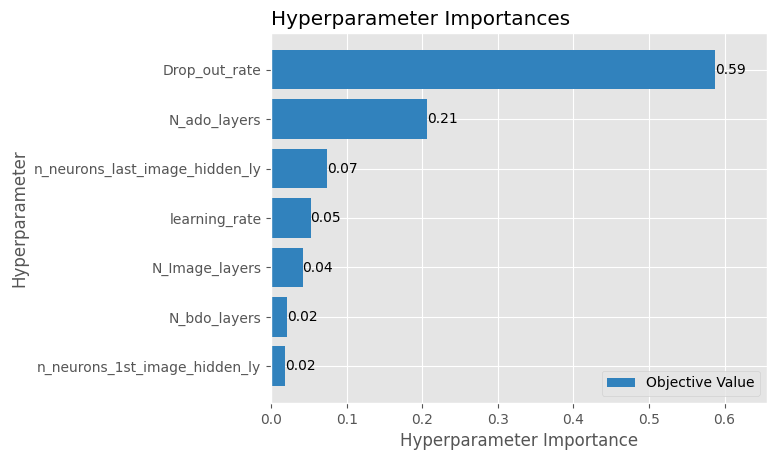

In [54]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.legend(loc = 'lower right')
#plt.savefig('figs/Optimized Models/10x10/Hyperparameter Importance.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [55]:
create_OP_Model(best_trial).summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_0 (Dense)               │ (None, 57)                │           5,757 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_1 (Dense)               │ (None, 39)                │           2,262 │ im_ly_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_2 (Dense)               │ (None, 33)                │           1,320 │ im_ly_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_3 (Dense)               │ (None, 31)                │           1,054 │ im_ly_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_4 (Dense)               │ (None, 30)                │             960 │ im_ly_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_5 (Dense)               │ (None, 30)                │             930 │ im_ly_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_6 (Dense)               │ (None, 30)                │             930 │ im_ly_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_7 (Dense)               │ (None, 30)                │             930 │ im_ly_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_8 (Dense)               │ (None, 30)                │             930 │ im_ly_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_9 (Dense)               │ (None, 30)                │             930 │ im_ly_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ energy_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ position_input (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32)                │               0 │ im_ly_9[0][0],             │
│                               │                           │                 │ energy_input[0][0],        │
│                               │                           │                 │ position_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer0 (Dense)            │ (None, 27)                │             891 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer1 (Dense)            │ (None, 26)                │             728 │ bdo_layer0[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,379 (91.32 KB)

 Trainable params: 23,379 (91.32 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
best_model = create_OP_Model(best_trial)
history = best_model.fit(x = {'image_input': pixel_train1_transf, 'energy_input': energy_train1_transf, 'position_input': position_train1_transf},
                    y = {'nu_predict':labels_train1}, 
                    epochs = 200, 
                    batch_size = 2000,
                    validation_data=([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 15, min_delta = 1e-3, monitor="val_loss")],
                    shuffle = True)

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 0.5008 - accuracy: 0.4955 - loss: 0.6931 - val_AUC: 0.5530 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - AUC: 0.5692 - accuracy: 0.5281 - loss: 0.6866 - val_AUC: 0.7548 - val_accuracy: 0.7692 - val_loss: 0.6049
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.7934 - accuracy: 0.7661 - loss: 0.5472 - val_AUC: 0.8690 - val_accuracy: 0.7681 - val_loss: 0.4411
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8679 - accuracy: 0.7788 - loss: 0.4389 - val_AUC: 0.8788 - val_accuracy: 0.8150 - val_loss: 0.4204
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8761 - accuracy: 0.8101 - loss: 0.4247 - val_AUC: 0.8810 - val_accuracy: 0.8172 - val_loss: 0.4168
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8786 - accuracy: 0.8130 - loss: 0.4198 - val_AUC: 0.8823 - val_accuracy: 0.8187 - val_loss: 0.4129
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

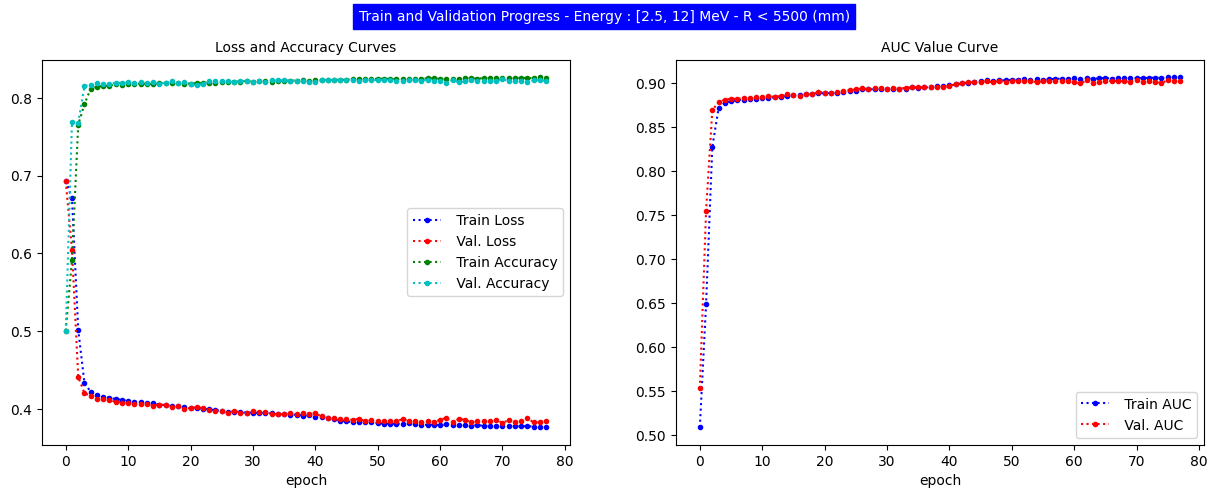

In [57]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Accuracy Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

#axes[0].set_ylim(0, 1.2)
#axes[1].set_ylim(0, 1.05)

#axes[0].set_xlim(-2, len(history.history['loss']))
#axes[1].set_xlim(-2, len(history.history['loss']))

fig.suptitle(f'Train and Validation Progress - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/Optimized Models/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Save the Train and Validation Progress of History

In [125]:
#Save training history as Pandas DataFrame
save = False  #Turn True to save the model!
load = False

save_dir = 'models/10x10/optimized models/MinMaxScaler_and_Norm_Vol_models/MinMax_0_1/' #+ new_folder for minmax Scaler + filename
train_history_name = f'train_history_MLM1_5500_(2.5_{energy_cut_train})_(-5_7)_aucOP_test_split.csv'

if save:    
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(save_dir+train_history_name, index=False)

if load:
    #Read saved learning progress
    hist_df = pd.read_csv(save_dir+train_history_name)

In [72]:
#Plots of learning curves of saved history

fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(hist_df['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(hist_df['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(hist_df['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(hist_df['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(hist_df['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(hist_df['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

axes[1].set_ylim(0, 1.05)


fig.suptitle('Train and Validation Progress - Energy : [2.5,12] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/Optimized Models/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')
plt.show()

NameError: name 'hist_df' is not defined

# *Save/Load Model

In [128]:
#Save model after training
save = False  #Turn True to save the model!
load = False
model_name = f'MLM2_5500_(2.5_{energy_cut_train})_(-5_7)_aucOP_test_split.h5'

if save:
    #save the model
    best_model.save(save_dir + model_name) #+ new_folder for minmax Scaler + filename

if load:
    #Load Model
    best_model = tf.keras.models.load_model(save_dir + model_name)
    best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_0 (Dense)               │ (None, 80)                │           8,080 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ energy_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ position_input (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_1 (Dense)               │ (None, 58)                │           4,698 │ im_ly_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ en_ly_0 (Dense)               │ (None, 1)                 │               2 │ energy_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pos_ly_0 (Dense)              │ (None, 1)                 │               2 │ position_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 60)                │               0 │ im_ly_1[0][0],             │
│                               │                           │                 │ en_ly_0[0][0],             │
│                               │                           │                 │ pos_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_0 (Dense)              │ (None, 45)                │           2,745 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer1 (Dense)            │ (None, 41)                │           1,886 │ bdo_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer2 (Dense)            │ (None, 37)                │           1,554 │ bdo_layer1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer3 (Dense)            │ (None, 33)                │           1,254 │ bdo_layer2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer4 (Dense)            │ (None, 30)                │           1,020 │ bdo_layer3[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 30)                │               0 │ bdo_layer4[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ado_ly_0 (Dense)              │ (None, 18)                │             558 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ado_ly_1 (Dense)              │ (None, 10)                │             190 │ ado_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,013 (85.99 KB)

 Trainable params: 22,011 (85.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Observation and Analysis of Predictions

## DNN Prediction

In [58]:
X_sig_pred = best_model.predict([pixel_test2_transf_sig, energy_test2_transf_sig, position_test2_transf_sig])
X_bkg_pred = best_model.predict([pixel_test2_transf_bkg, energy_test2_transf_bkg, position_test2_transf_bkg])

727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [59]:
X_sig_pred

array([[1.7217030e-01, 8.2759988e-01],
       [1.8403943e-01, 8.1580693e-01],
       [9.9982232e-01, 2.4733474e-04],
       ...,
       [1.0000000e+00, 1.2369623e-29],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [60]:
X_bkg_pred

array([[0.08991735, 0.9112485 ],
       [0.4875374 , 0.5153128 ],
       [0.13672681, 0.8637248 ],
       ...,
       [0.5919869 , 0.41002357],
       [0.35551947, 0.6474056 ],
       [0.20051363, 0.7990094 ]], dtype=float32)

In [38]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 18983 of signal and 18984 of background as testing data


## Representation of Predictions

### Distribution of Probabilities

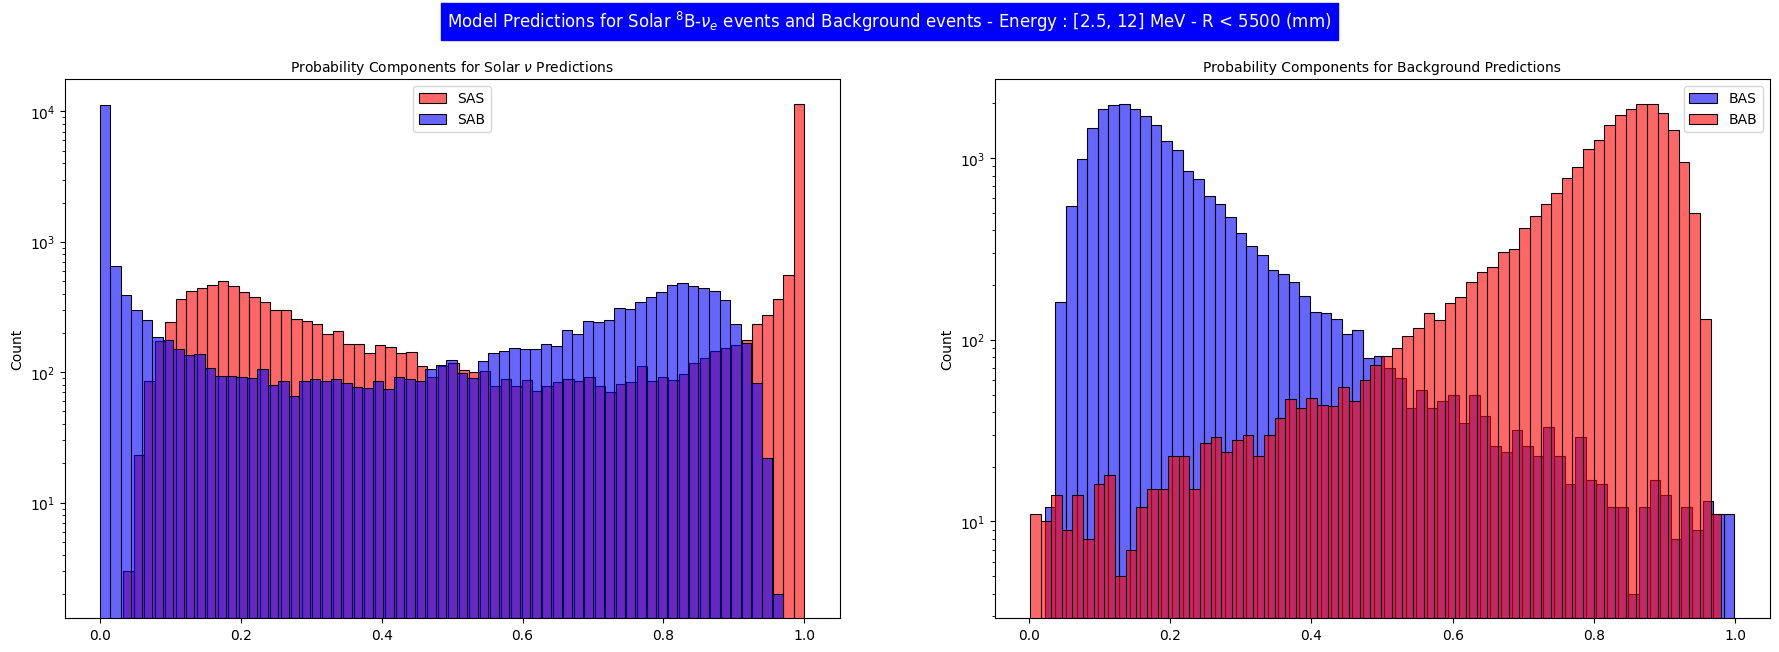

In [61]:
sn.reset_orig
bins = 65
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'SAS', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'SAB', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'BAS',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'BAB', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')
plt.suptitle(f'Model Predictions for Solar $^8$B-$ν_e$ events and Background events - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
#plt.savefig('figs/Optimized Models/10x10/probability_predictions1.png', format = 'png', bbox_inches = 'tight')
plt.show()

### ROC Curve

In [62]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))              #Predicted
X_exp = np.concatenate((labels_test2_sig, labels_test2_bkg))   #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

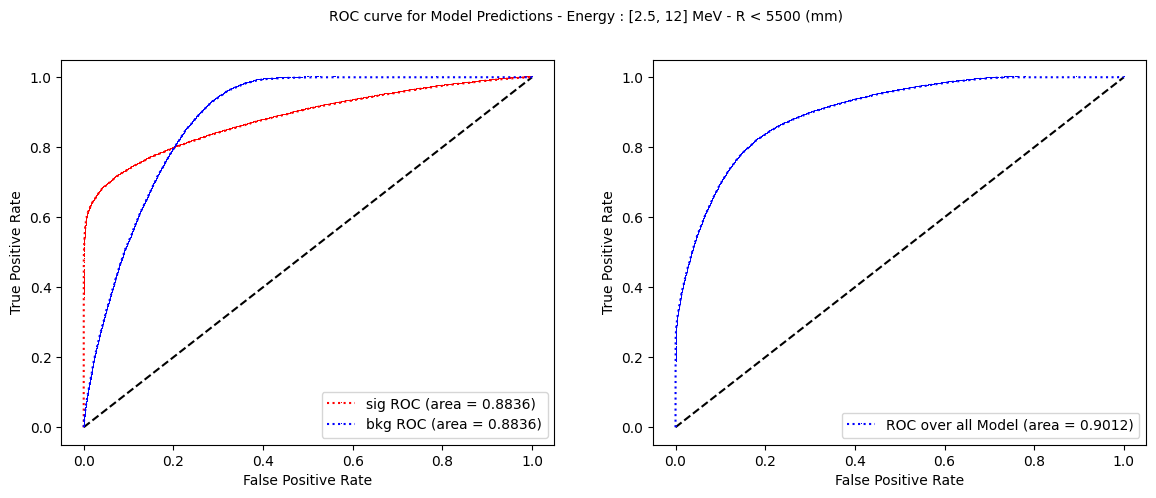

In [63]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.4f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.4f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.4f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle(f'ROC curve for Model Predictions - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC.png', format = 'png', bbox_inches = 'tight')
plt.show()

###  Reconstrucción de espector de solar $ν_e$ y de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio (Inverse Standard Scaler) y Normalización en Volumen

In [64]:
energy_sig_rc = scaler_energy_test.inverse_transform([energy_test2_transf_sig])[0]
energy_bkg_rc = scaler_energy_test.inverse_transform([energy_test2_transf_bkg])[0]

# Volume Normalization + Std Scaler: la formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
#Recover from Transformation Rule
position_sig_rc = scaler_position_test.inverse_transform([position_test2_transf_sig])[0]
position_bkg_rc = scaler_position_test.inverse_transform([position_test2_transf_bkg])[0]

#Recover the radius values from the Volume
radi_sig_rc = np.cbrt(position_sig_rc*vol)
radi_bkg_rc = np.cbrt(position_bkg_rc*vol)

### Normalized Efficiency by N_Counts(true)

Construir un plot de eficicencia normalizada por el numero total de eventos en un bin del plot "Separated Spectrums for Threshold (trh)".
Procedimientos de construcción:

1) extraer valores de energia contenidos en cada bin de "Separated Spectrums for Threshold (trh)"
2) Contabilizar el nº de eventos que superan el treshold dentro del bin de energia, y dividir por el número de eventos contenido en el bin, esta será la eficiencia normalizado por N_events_true
3) Hacer plot de la eficiciencia normalizada en funcion del valor medio de las energias contenida en el bin (cuanto mas bins, mas puntos de eficiencia habra)

#### Graficos de Energia Reconstruida y de Eficiencia Normalizada para varios Threshold de Predicción del Modelo

##### Extraer Información para los Gráficos

In [65]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_nu = 15             #-> Define how many intervals in energy. Equals to the number of point of norm_eff. PREDEFINED BINS = 20
bins_tl = 8              #-> BINS = 8

thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]      #probiblity of the event of neutrino being detected as neutrino
#prob_bab = X_bkg_pred[:,1]      #probiblity of the event of thallium being detected as thallium
prob_bas = X_bkg_pred[:,0]      #probiblity of the event of thallium being detected as neutrino

en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins_nu)   #Extract interval of binned data
en_bkg_test_count, en_bkg_test_edge = np.histogram(energy_bkg_rc, bins = bins_tl)   #Extract interval of binned data


N_edges_sig = len(en_sig_test_edge)
N_edges_bkg = len(en_bkg_test_edge)

#Information to extract--------------------------------------
nu_energy_in_sas = []
#nu_energy_out_sas = []

tl_energy_in_bas = []
#tl_energy_out_bab = []

#mean normalized eficiency values for signal as signal and bkg as sig
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []

norm_eff_bkg = []

#mean energy within each bin for signal and bkg data
mean_energy_sig = []  
mean_energy_bkg = []   

for thr_i in thr: 

    #Information to save in each loop of threshold --------------
    nu_energy_in_sas_thr = []
    #nu_energy_out_sas_thr = []
    
    tl_energy_in_bas_thr = []
    #tl_energy_out_bas_thr = []

    #normalized eficiency values for signal and bkg for each thr
    #Used to contruct the norm eff plot
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])

    #mean energy within each bin for signal and bkg data for each thr (aunque acaba siendo el mismo valor medio para cado thr y para los histogramas que preservan el número de bins).
    #Used to contruct the norm eff plot
    mean_energy_sig_thr = np.array([]) 
    mean_energy_bkg_thr = np.array([]) 

    #mean radial values within each bin for signal and bkg data for each thr
    #Used to contruct the norm eff plot
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract info for Plot of energy > thr and energy < thr

    #Extract
    for i in np.where(prob_sas >= thr_i)[0]:
        nu_energy_in_sas_thr.append(energy_sig_rc[i])
        
    #for j in np.where(prob_sas < thr_i)[0]:
        #nu_energy_out_sas_thr.append(energy_sig_rc[j])
    
    for m in np.where(prob_bas >= thr_i)[0]:
        tl_energy_in_bas_thr.append(energy_bkg_rc[m])
    
    #for k in np.where(prob_bab < thr_i)[0]:
        #tl_energy_out_spectrum_thr.append(energy_bkg_rc[k])
        
    nu_energy_in_sas.append(np.array(nu_energy_in_sas_thr))
    #nu_energy_out_sas.append(np.array(nu_energy_out_sas_thr))
    tl_energy_in_bas.append(np.array(tl_energy_in_bas_thr))
    #tl_energy_out_bab.append(np.array(tl_energy_out_spectrum_thr))

    #Extract norm_eff and mean nu enery within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges_sig-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_sig_test_edge[i]
        energy_edge_f = en_sig_test_edge[i+1]
    
        #find energy in energy_test_sig between edges values and the model prediction for SAS 
        energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), energy_sig_rc)
        prob_sas_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), prob_sas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_sig_thr = np.append(mean_energy_sig_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_energy_sig.append(mean_energy_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges_bkg-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_bkg_test_edge[i]
        energy_edge_f = en_bkg_test_edge[i+1]
    
        #find energy in energy_test_bkg between edges values and the model prediction for BAS
        energy_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), energy_bkg_rc)
        prob_bas_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), prob_bas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_bkg_thr = np.append(mean_energy_bkg_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_energy_bkg.append(mean_energy_bkg_thr)

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_energy_sig = np.array(mean_energy_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_energy_bkg = np.array(mean_energy_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

In [66]:
norm_eff_sig_in_sas

array([[0.29903978, 0.        , 0.        , 0.29754158, 0.9961945 ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.50342936, 0.        , 0.00295955, 0.56760665, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.57668038, 0.        , 0.00789214, 0.67389732, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]])

#### Construir los Gráficos

- Energia

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


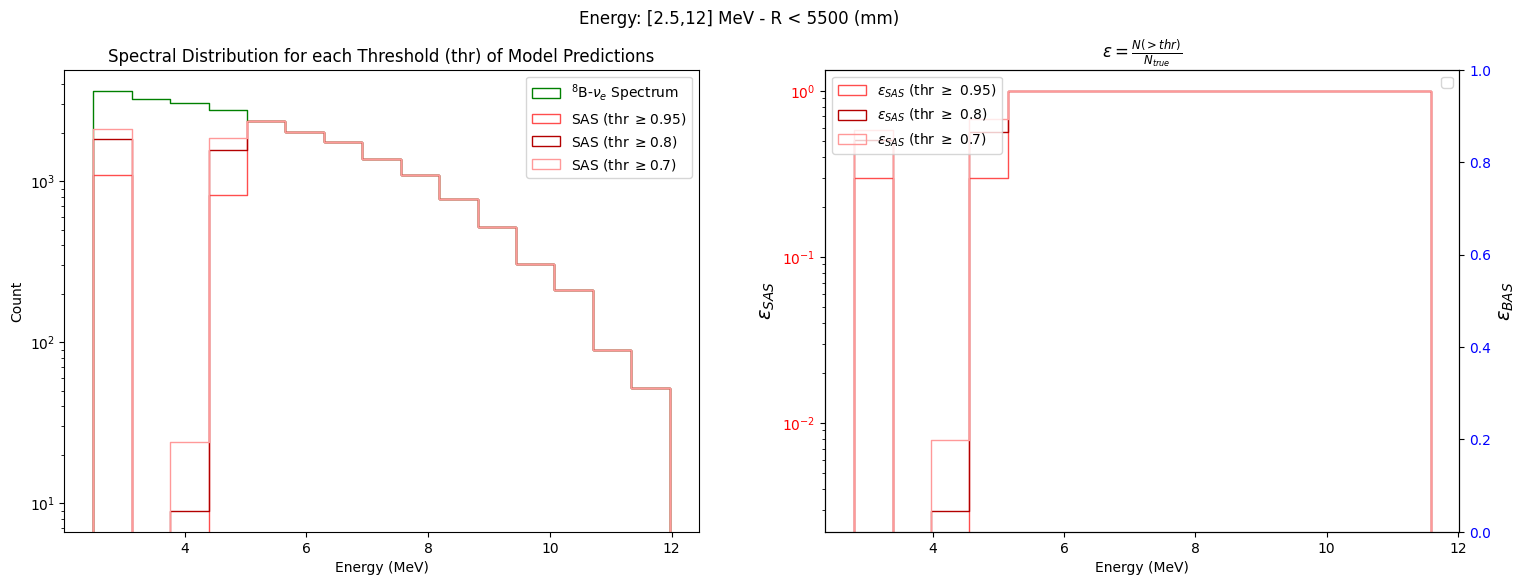

In [67]:
bas_on = False
alpha = 0

#main plot: Test Solar Energy
fig, axes = plt.subplots(1,2, figsize =(18, 6)) 
ax1_1 = axes[1].twinx()  #Right axis for the norm_eff plot due to differences between eff scales

sn.histplot(energy_sig_rc, ax = axes[0], bins = bins_nu, color = 'g' , label = r'$^8$B-$ν_e$ Spectrum', alpha = alpha, element = 'step')

#if bkg_on:
#Bkg test energy plot
#    sn.histplot(energy_bkg_rc, ax = axes[0], bins = bins_tl, color = 'black' , label = r'208-Tl Spectrum', alpha = alpha, element = 'step')

for i_dx, thr_i in enumerate(thr):  
    #Sig Spectral distribution
    sn.histplot(nu_energy_in_sas[i_dx], ax = axes[0], bins = bins_nu, color = red_variants[i_dx] , label = r'SAS (thr $\geq$'+str(thr_i)+')', 
                alpha = alpha, element = 'step')

    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_energy_sig[i_dx], ax = axes[1], bins=len(mean_energy_sig[i_dx]), color = red_variants[i_dx], 
                weights=norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$ (thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg spectra
        sn.histplot(tl_energy_in_bas[i_dx], ax = axes[0], bins = bins_tl, color = blue_variants[i_dx] , label = r'BAS (thr $\geq$'+str(thr_i)+')', 
                    alpha = alpha, element = 'step')

        #bkg efficiency
        sn.histplot(x = mean_energy_bkg[i_dx], ax = ax1_1, bins=len(mean_energy_bkg[i_dx]), color = blue_variants[i_dx], 
                    weights=norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$ (thr $\geq$ '+str(thr_i)+')')
        

axes[0].set_title(r'Spectral Distribution for each Threshold (thr) of Model Predictions', fontsize = 12)
axes[1].set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')
ax1_1.legend(loc = 'upper right')

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Energy (MeV)')
axes[1].set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
ax1_1.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

axes[1].tick_params(axis='y', labelcolor='r')
ax1_1.tick_params(axis='y', labelcolor='b')


#Agregar marcadores al eje x
#x_en_ticks = np.arange(2.5, 12, 1)   #(x_min, x_max, step)
#axes[0].x_en_ticks(x_ticks)
#axes[1].x_en_ticks(x_ticks)


#axes[0].set_xlim(2.5,12.8)
#axes[1].set_xlim(2.5,12)
#axes[1].set_ylim(np.min(norm_eff_sig_in_sas) - 0.05, 1.05)
#ax1_1.set_ylim(0.0, np.max(norm_eff_bkg_in_bas) + 0.01)

axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.suptitle(f'Energy: [2.5,{energy_cut_train}] MeV - R < 5500 (mm)')

#if bas_on:
    #plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff_sig_bkg.png', format = 'png', bbox_inches = 'tight')
#else:
    #plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [119]:
# Mean eficiency calculation in [2.5,10] for each thr in SAS

mean_eff = []  # List with the values of the mean efficicency for each threshold in energy within a range [2.5,10] MeV
eff_error = [] # list with the error value associated to hte mean_eff by the maximum desviation.
results = []   # List with explicit result of the thr and mean value of efficiency

for i_dx, thr_i in enumerate(thr):

    eff_sas_thr = norm_eff_sig_in_sas[i_dx]
    energy_sas_thr = mean_energy_sig[i_dx]
    
    #Extract the values of efficiency which verifies the energy cut
    condition = (energy_sas_thr <= 10)
    eff_sas_filter = np.extract(condition, eff_sas_thr)

    #Obtain mean value as the mean percentage of events in thr which are truly solar nu
    mean_eff_sas_thr = np.mean(eff_sas_filter, dtype = np.float16)
    mean_eff.append(mean_eff_sas_thr)

    #Compute the eff error by the maximum deviation of the samples from the mean value
    deviations = abs(eff_sas_thr -  mean_eff_sas_thr)
    max_deviation = np.max(deviations)
    eff_error.append(max_deviation)

    result_thr = 'For thr='+str(thr_i) + r', the eff for SAS is = ' + str(mean_eff_sas_thr) + ' with an error of ' + str(max_deviation)
    results.append(result_thr)

In [120]:
mean_eff

[0.529, 0.614, 0.6455]

In [121]:
eff_error

[0.52880859375, 0.61376953125, 0.6455078125]

In [122]:
results

['For thr=0.95, the eff for SAS is = 0.529 with an error of 0.52880859375',
 'For thr=0.8, the eff for SAS is = 0.614 with an error of 0.61376953125',
 'For thr=0.7, the eff for SAS is = 0.6455 with an error of 0.6455078125']

- Radius

In [123]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_rad = 20            #-> BINS = 20
thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]
prob_bas = X_bkg_pred[:,0]

rad_sig_test_count, rad_sig_test_edge = np.histogram(radi_sig_rc, bins = bins_rad)
rad_bkg_test_count, rad_bkg_test_edge = np.histogram(radi_bkg_rc, bins = bins_rad)

N_edges= len(rad_sig_test_edge)

#mean normalized eficiency values for signal and bkg
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []  

#mean radial values within each bin for signal and bkg data
mean_rad_sig = []
mean_rad_bkg = []

for thr_i in thr: 

    #mean normalized eficiency values for signal and bkg for each thr
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])
    
    #mean radial values within each bin for signal and bkg data for each thr
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract norm_eff and mean radius within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges-1):
        #extract edges value of energy at each bin
        radi_edge_i = rad_sig_test_edge[i]
        radi_edge_f = rad_sig_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), radi_sig_rc)
        prob_sas_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), prob_sas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_sig_thr = np.append(mean_rad_sig_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_rad_sig.append(mean_rad_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges-1):
        #extract edges value of radius at each bin
        radi_edge_i = rad_bkg_test_edge[i]
        radi_edge_f = rad_bkg_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), radi_bkg_rc)
        prob_bas_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), prob_bas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_bkg_thr = np.append(mean_rad_bkg_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract value of normalized efficiency for each bin
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_rad_bkg.append(mean_rad_bkg_thr)
    

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_rad_sig = np.array(mean_rad_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_rad_bkg = np.array(mean_rad_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


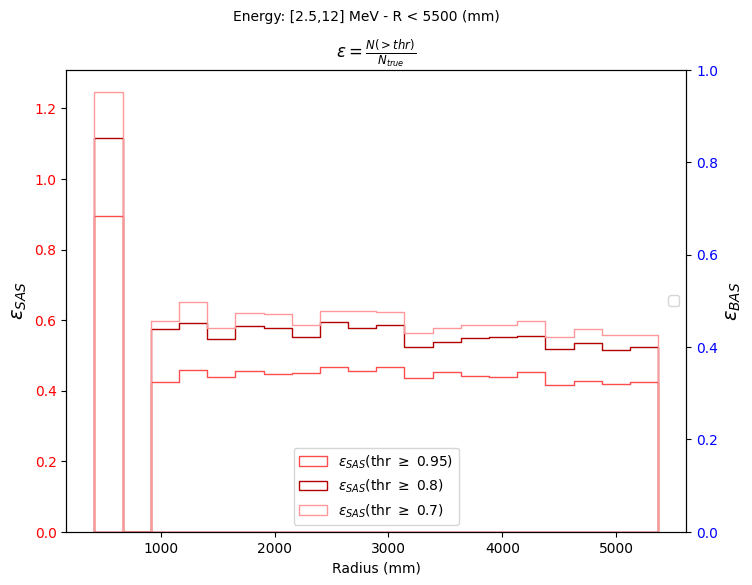

In [124]:
bas_on = False

#main plot: Test Solar radius vs. Normalized efficiency
fig, axes_1 = plt.subplots(figsize =(8, 6))
axes_2 = axes_1.twinx()

for i_dx, thr_i in enumerate(thr):  
    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_rad_sig[i_dx], ax = axes_1,bins = len(mean_rad_sig[i_dx]), color = red_variants[i_dx], 
                weights = norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$(thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg efficiency
        sn.histplot(x = mean_rad_bkg[i_dx], ax = axes_2, bins=len(mean_rad_bkg[i_dx]), color = blue_variants[i_dx], kde=False,
                    weights = norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$(thr $\geq$ '+str(thr_i)+')')
        

plt.suptitle('Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 10)
axes_1.set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes_1.legend(loc = 'lower center')
axes_2.legend(loc = 'center right')

axes_1.tick_params(axis='y', labelcolor='r')
axes_2.tick_params(axis='y', labelcolor='b')


axes_1.set_xlabel('Radius (mm)')
axes_1.set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
axes_2.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

#axes_1.set_xlim(0, 5500.0)
#axes_2.set_ylim(0, np.max(norm_eff_bkg_in_bas) + 0.15)
#axes_1.set_yscale('log')

#if bas_on:
#    plt.savefig('figs/Optimized Models/10x10/Radial_sig_bkg_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
#else:
#    plt.savefig('figs/Optimized Models/10x10/Radial_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()